In [ ]:
%run ./model_end_events_for_outages_METHODS.ipynb

In [1]:
from importlib import reload
#reload(Utilities)
#reload(clm)
# NOTE: To reload a class imported as, e.g., 
# from module import class
# One must call:
#   1. import module
#   2. reload module
#   3. from module import class

import sys, os
import re
import string

from pathlib import Path
import json
import pickle

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version
import copy
from functools import reduce

import itertools

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.colors as mcolors
import matplotlib.cm as cm #e.g. for cmap=cm.jet
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
from EEMSP import EEMSP
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIEDE_DEV import AMIEDE_DEV
from MECPODf import MECPODf
from MECPOAn import MECPOAn
from MECPOCollection import MECPOCollection
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_General
import Plot_Box_sns
import Plot_Hist
import Plot_Bar
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer

In [2]:
from sklearn.preprocessing import OrdinalEncoder

In [3]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

import scipy

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# SAVE OR LOAD

In [15]:
combine_others=True
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\Models'
# save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\Models - Copy'


merged_df_full=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
merged_df_drct=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_drct.pkl'))
merged_df_no_outg=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
merged_df_no_outg_prstn=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
#-------------------------
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'rb') as handle:
#     mecpo_coll_full = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_drct.pkl'), 'rb') as handle:
#     mecpo_coll_drct = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'rb') as handle:
#     mecpo_coll_no_outg = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'rb') as handle:
#     mecpo_coll_no_outg_prstn = pickle.load(handle)
#-------------------------
with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'rb') as handle:
    counts_series_full = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_drct.pkl'), 'rb') as handle:
    counts_series_drct = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'rb') as handle:
    counts_series_no_outg = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'rb') as handle:
    counts_series_no_outg_prstn = pickle.load(handle)
    
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
merged_df_no_outg_prstn.index.names     = ['trsf_pole_nb', 'no_outg_rec_nb']
counts_series_no_outg_prstn.index.names = ['trsf_pole_nb', 'no_outg_rec_nb']

In [16]:
print(merged_df_full.shape)
print(merged_df_drct.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(651039, 288)
(2673, 288)
(346271, 288)
(440437, 288)


# !!!!!!! No outage data have indices backwards from outages!!!!!


In [17]:
merged_df_no_outg = merged_df_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg = counts_series_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()
#-----
merged_df_no_outg_prstn = merged_df_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg_prstn = counts_series_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()

In [ ]:
# addtnl_baseline_train = pd.concat([merged_df_no_outg_train, merged_df_no_outg_prstn_train])

In [18]:
merged_df_full

mecpo_an_key                                                             01-05 Days  \
                          Access Point has lost connectivity with FHSS 900 MHz band   
outg_rec_nb trsf_pole_nb                                                              
11411973    1869998706196                                                0.0          
11412057    1862303696797                                                0.0          
11412058    1822777754677                                                0.0          
            1822823754464                                                0.0          
            1822841754295                                                0.0          
...                                                                      ...          
21243680    1901827733753                                                0.0          
            1902844734693                                                0.0          
            1902878733629                                                0.0          
            1905199734711                                                0.0          
            1908106734512                                                0.0          

mecpo_an_key                                                                \
                          DSP Error (C1219 Table 3: Er200000) Demand Reset   
outg_rec_nb trsf_pole_nb                                                     
11411973    1869998706196                                 0.0          0.0   
11412057    1862303696797                                 0.0          0.0   
11412058    1822777754677                                 0.0          0.0   
            1822823754464                                 0.0          0.0   
            1822841754295                                 0.0          0.0   
...                                                       ...          ...   
21243680    1901827733753                                 0.0          0.0   
            1902844734693                                 0.0          0.0   
            1902878733629                                 0.0          0.0   
            1905199734711                                 0.0          0.0   
            1908106734512                                 0.0          0.0   

mecpo_an_key                                           \
                          Detected end of voltage sag   
outg_rec_nb trsf_pole_nb                                
11411973    1869998706196                         0.0   
11412057    1862303696797                         0.0   
11412058    1822777754677                         0.0   
            1822823754464                         0.0   
            1822841754295                         0.0   
...                                               ...   
21243680    1901827733753                         0.0   
            1902844734693                         0.0   
            1902878733629                         0.0   
            1905199734711                         0.0   
            1908106734512                         0.0   

mecpo_an_key                                             \
                          Detected end of voltage swell   
outg_rec_nb trsf_pole_nb                                  
11411973    1869998706196                           0.0   
11412057    1862303696797                           0.0   
11412058    1822777754677                           0.0   
            1822823754464                           0.0   
            1822841754295                           0.0   
...                                                 ...   
21243680    1901827733753                           0.0   
            1902844734693                           0.0   
            1902878733629                           0.0   
            1905199734711                           0.0   
            1908106734512                           0.0   

mecpo_an_key                                                  

In [21]:
print(merged_df_full.columns.get_level_values(1).nunique())
print(merged_df_no_outg.columns.get_level_values(1).nunique())
print(merged_df_no_outg_prstn.columns.get_level_values(1).nunique())

48
48
48


In [27]:
MECPOCollection.get_top_reasons_subset_from_merged_cpo_df(merged_df_full, n_reasons_to_include=48, combine_others=False).sum()

01-05 Days  Primary Power Down                                                                                          28090.800615
            Primary Power Up                                                                                            25420.234173
            NET_MGMT command failed consecutively                                                                       24696.065656
            Under Voltage for meter                                                                                     23882.458897
            NIC Power Restore Trap Received from device                                                                 15050.642927
                                                                                                                            ...     
26-30 Days  NET_MGMT command was sent with a key that has insufficient privileges: READ SUBID: 65535 ASSOC_ID: 7317         0.000000
            NET_MGMT command was sent with a key that has insufficien

# ---------------------------------------------------------------------------------------------------

# Add date info

In [28]:
merged_df_full_wd = DOVSOutages.append_outg_dt_off_ts_full_to_df(
    df=merged_df_full.copy(), 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    dummy_col_levels_prefix='dummy_lvl_'
)

In [29]:
merged_df_drct_wd = DOVSOutages.append_outg_dt_off_ts_full_to_df(
    df=merged_df_drct.copy(), 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    dummy_col_levels_prefix='dummy_lvl_'
)

In [30]:
build_no_outg_time_infos_dfs=False
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\Models'


if build_no_outg_time_infos_dfs:
    ede_data_dir_no_outg_2020 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20200101_20201231\EndEvents_NoOutg'
    ede_data_dir_no_outg_2021 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20210101_20211231\EndEvents_NoOutg'
    ede_data_dir_no_outg_2022 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20220101_20220930\EndEvents_NoOutg'
    #-------------------------
    no_outg_time_infos_df_2020 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_2020)
    no_outg_time_infos_df_2021 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_2021)
    no_outg_time_infos_df_2022 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_2022)
    #-------------------------
    no_outg_time_infos_df = pd.concat([no_outg_time_infos_df_2020, no_outg_time_infos_df_2021, no_outg_time_infos_df_2022])
    #-------------------------
    no_outg_time_infos_df.to_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
else:
    no_outg_time_infos_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
#--------------------------------------------------    
#--------------------------------------------------    
if build_no_outg_time_infos_dfs:
#     ede_data_dir_no_outg_prstn_2020 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221014\20200101_20201231\EndEvents_NoOutg'
#     ede_data_dir_no_outg_prstn_2021 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221014\20210101_20211231\EndEvents_NoOutg'
#     ede_data_dir_no_outg_prstn_2022 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221014\20220101_20220930\EndEvents_NoOutg'
    ede_data_dir_no_outg_prstn_2020 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20200101_20201231\NoOutgs_Pristine\EndEvents'
    ede_data_dir_no_outg_prstn_2021 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20210101_20211231\NoOutgs_Pristine\EndEvents'
    ede_data_dir_no_outg_prstn_2022 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20220101_20221231\NoOutgs_Pristine\EndEvents'
    #-------------------------
    no_outg_time_infos_df_prstn_2020 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_prstn_2020)
    no_outg_time_infos_df_prstn_2021 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_prstn_2021)
    no_outg_time_infos_df_prstn_2022 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_prstn_2022)
    #-------------------------
    no_outg_time_infos_prstn_df = pd.concat([no_outg_time_infos_df_prstn_2020, no_outg_time_infos_df_prstn_2021, no_outg_time_infos_df_prstn_2022])
    #-------------------------
    no_outg_time_infos_prstn_df.to_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))
else:
    no_outg_time_infos_prstn_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))

In [31]:
merged_df_no_outg_wd = merge_cpx_df_w_time_infos(
    cpx_df=merged_df_no_outg.copy(), 
    time_infos_df=no_outg_time_infos_df, 
    time_infos_drop_dupls_subset=['index', 't_min']
)

In [32]:
merged_df_no_outg_prstn_wd = merge_cpx_df_w_time_infos(
    cpx_df=merged_df_no_outg_prstn.copy(), 
    time_infos_df=no_outg_time_infos_prstn_df, 
    time_infos_drop_dupls_subset=['index', 't_min']
)

In [41]:
merged_df_full_wd[('dummy_lvl_0', 'year_and_month')] = merged_df_full_wd[('dummy_lvl_0', 'DT_OFF_TS_FULL')].dt.strftime('%Y-%m')
merged_df_drct_wd[('dummy_lvl_0', 'year_and_month')] = merged_df_drct_wd[('dummy_lvl_0', 'DT_OFF_TS_FULL')].dt.strftime('%Y-%m')

#-------------------------
merged_df_no_outg_wd[('dummy_lvl_0', 'year_and_month')] = merged_df_no_outg_wd[('dummy_lvl_0', 't_min')].dt.strftime('%Y-%m')
merged_df_no_outg_prstn_wd[('dummy_lvl_0', 'year_and_month')] = merged_df_no_outg_prstn_wd[('dummy_lvl_0', 't_min')].dt.strftime('%Y-%m')

#-------------------------
# merged_df_full_wd = merged_df_full_wd.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])
# merged_df_drct_wd = merged_df_drct_wd.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])
# merged_df_no_outg_wd = merged_df_no_outg_wd.drop(columns=[('dummy_lvl_0', 't_min')])
# merged_df_no_outg_prstn_wd = merged_df_no_outg_prstn_wd.drop(columns=[('dummy_lvl_0', 't_min')])

In [45]:
merged_df_full=merged_df_full_wd.copy()
merged_df_drct=merged_df_drct_wd.copy()
merged_df_no_outg=merged_df_no_outg_wd.copy()
merged_df_no_outg_prstn=merged_df_no_outg_prstn_wd.copy()

# ---------------------------------------------------------------------------------------------------

In [47]:
merged_df_full = merged_df_full.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])
merged_df_drct = merged_df_drct.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])

merged_df_no_outg       = merged_df_no_outg.drop(columns=[('dummy_lvl_0', 't_min')])
merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=[('dummy_lvl_0', 't_min')])

In [113]:
# reason_sums_by_monthyear_full = merged_df_full.groupby(('dummy_lvl_0', 'year_and_month')).sum()
# reason_sums_by_monthyear_drct = merged_df_drct.groupby(('dummy_lvl_0', 'year_and_month')).sum()

# reason_sums_by_monthyear_no_outg = merged_df_no_outg.groupby(('dummy_lvl_0', 'year_and_month')).sum()
# reason_sums_by_monthyear_no_outg_prstn = merged_df_no_outg_prstn.groupby(('dummy_lvl_0', 'year_and_month')).sum()


reason_sums_by_monthyear_full = merged_df_full.groupby(('dummy_lvl_0', 'year_and_month')).mean()
reason_sums_by_monthyear_drct = merged_df_drct.groupby(('dummy_lvl_0', 'year_and_month')).mean()

reason_sums_by_monthyear_no_outg = merged_df_no_outg.groupby(('dummy_lvl_0', 'year_and_month')).mean()
reason_sums_by_monthyear_no_outg_prstn = merged_df_no_outg_prstn.groupby(('dummy_lvl_0', 'year_and_month')).mean()

In [114]:
reason_sums_by_monthyear_full

mecpo_an_key                                                                 01-05 Days  \
                              Access Point has lost connectivity with FHSS 900 MHz band   
(dummy_lvl_0, year_and_month)                                                             
2020-01                                                                 0.000000          
2020-02                                                                 0.000000          
2020-03                                                                 0.000000          
2020-04                                                                 0.000000          
2020-05                                                                 0.000000          
2020-06                                                                 0.000000          
2020-07                                                                 0.000000          
2020-08                                                                 0.000000          
2020-09                                                                 0.000000          
2020-10                                                                 0.000000          
2020-11                                                                 0.000000          
2020-12                                                                 0.000000          
2021-01                                                                 0.000275          
2021-02                                                                 0.000019          
2021-03                                                                 0.000243          
2021-04                                                                 0.000059          
2021-05                                                                 0.000102          
2021-06                                                                 0.000134          
2021-07                                                                 0.000188          
2021-08                                                                 0.000191          
2021-09                                                                 0.000099          
2021-10                                                                 0.000145          
2021-11                                                                 0.000068          
2021-12                                                                 0.000150          
2022-01                                                                 0.000223          
2022-02                                                                 0.000330          
2022-03                                                                 0.000125          
2022-04                                                                 0.000182          
2022-05                                                                 0.000348          
2022-06                                                                 0.000258          
2022-07                                                                 0.000462          
2022-08                                                                 0.000203          
2022-09                                                                 0.000388          

mecpo_an_key                                                       \
                              DSP Error (C1219 Table 3: Er200000)   
(dummy_lvl_0, year_and_month)                                       
2020-01                                                       0.0   
2020-02                                                       0.0   
2020-03                                                       0.0   
2020-04                                                       0.0   
2020-05                                                       0.0   
2020-06                                                       0.0   
2020-07                                                       0.0   
2020-08                          

In [115]:
reason_sums_by_monthyear_full.iloc[[0]]['01-05 Days']

,Access Point has lost connectivity with FHSS 900 MHz band,DSP Error (C1219 Table 3: Er200000),Demand Reset,Detected end of voltage sag,Detected end of voltage swell,Device Failed: Reason: Security public key mismatch,Device Failed: Reason: unknown (0x4),Device Failed: Reason: unknown (0x6),Device exceeded the max allowable trap threshold,"Diag1: Polarity, Cross Phase, Reverse Energy Flow: Angle out of tolerance",...,Requested operation could not be applied: JOB_OP_NEW_DATA_READ,Requested operation could not be applied: JOB_OP_PROVISION_CONNECT,Requested operation could not be applied: JOB_OP_PROVISION_DISCONNECT,Requested operation could not be applied: JOB_OP_PROVISION_GET_STATUS,Requested operation could not be applied: JOB_OP_REGISTER_CURR_READ,Requested operation could not be applied: JOB_OP_TYPE_ARB_METER_COMMAND,Secure association operation failed consecutively,System Error (C1219 Table 3: Er000020),Tamper (Meter Inversion) detected,Under Voltage for meter
"(dummy_lvl_0, year_and_month)",,,,,,,,,,,,,,,,,,,,,
2020-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014591


<AxesSubplot:title={'center':'2020-01, 01-05 Days'}>

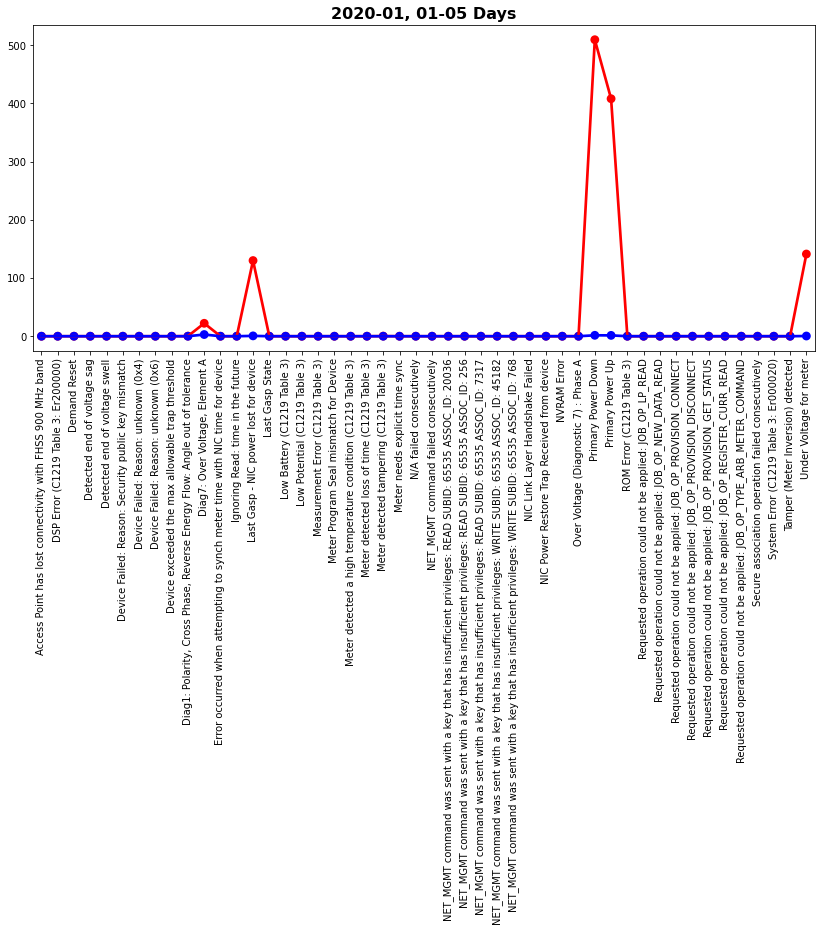

In [102]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_full.loc[['2020-01'], '01-05 Days'], 
    color='red'
)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_no_outg.loc[['2020-01'], '01-05 Days'], 
    color='blue'
)
Plot_General.set_general_plotting_args(
    axs, 
#     draw_legend=True, 
#     legend_args=dict(loc='upper right', fontsize=20), 
    title_args=dict(label='2020-01, 01-05 Days', fontdict=dict(fontweight='semibold', fontsize=16)), 
#     xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
#     ylabel_args=dict(ylabel=y_col, loc='top', fontdict=dict(fontsize=16)), 
    tick_args=dict(axis='x', labelrotation=90)
)

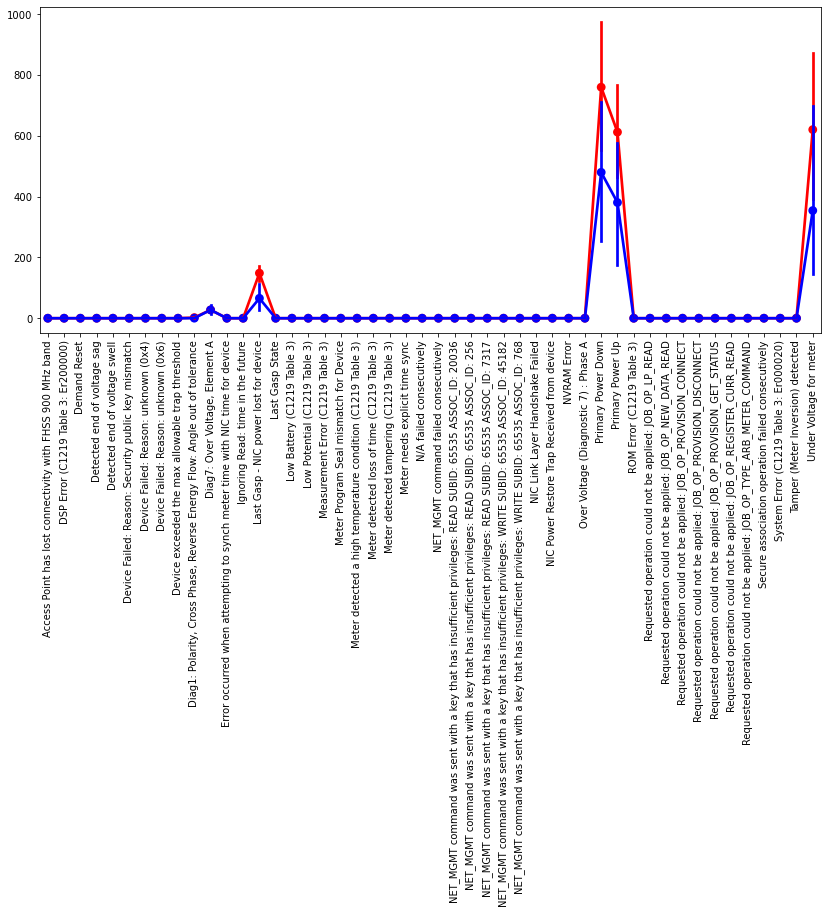

In [96]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_full.loc['2020-01':'2020-12', '01-05 Days'], 
    color='red'
)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_no_outg.loc['2020-01':'2020-12', '01-05 Days'], 
    color='blue'
)
Plot_General.rotate_ticklabels(axs, 90)

In [92]:
reason_sums_by_monthyear_full.loc['2020-01', :]

mecpo_an_key                                                                         
01-05 Days    Access Point has lost connectivity with FHSS 900 MHz band                    0.000000
              DSP Error (C1219 Table 3: Er200000)                                          0.000000
              Demand Reset                                                                 0.000000
              Detected end of voltage sag                                                  0.000000
              Detected end of voltage swell                                                0.000000
                                                                                            ...    
26-30 Days    Requested operation could not be applied: JOB_OP_TYPE_ARB_METER_COMMAND      0.000000
              Secure association operation failed consecutively                            0.000000
              System Error (C1219 Table 3: Er000020)                                       0.000000
              

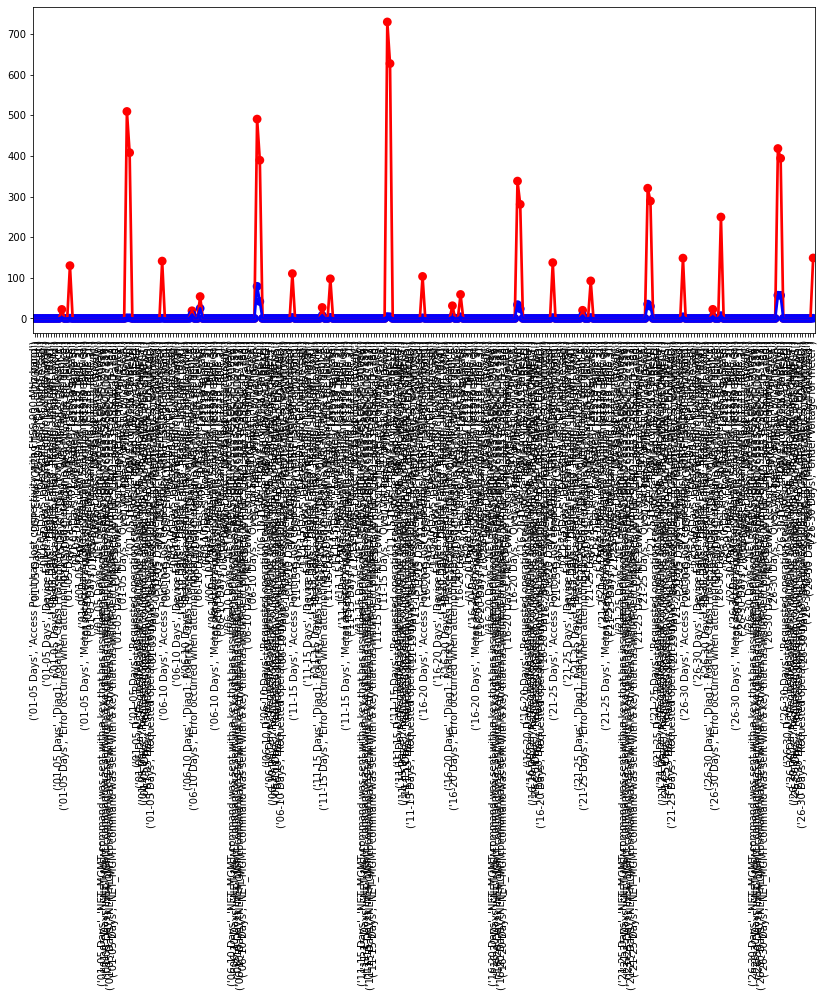

In [93]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_full.loc[['2020-01'], :], 
    color='red'
)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_no_outg.loc[['2020-01'], :], 
    color='blue'
)
Plot_General.rotate_ticklabels(axs, 90)

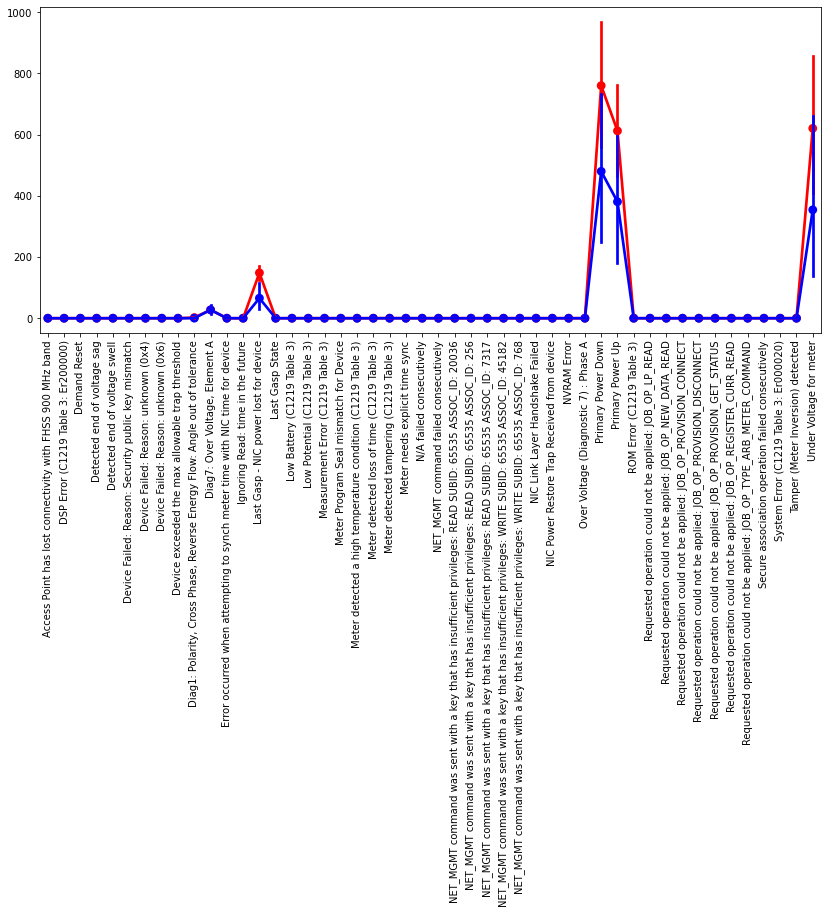

In [87]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_full.loc['2020-01':'2020-12', '01-05 Days'], 
    color='red'
)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_no_outg.loc['2020-01':'2020-12', '01-05 Days'], 
    color='blue'
)
Plot_General.rotate_ticklabels(axs, 90)

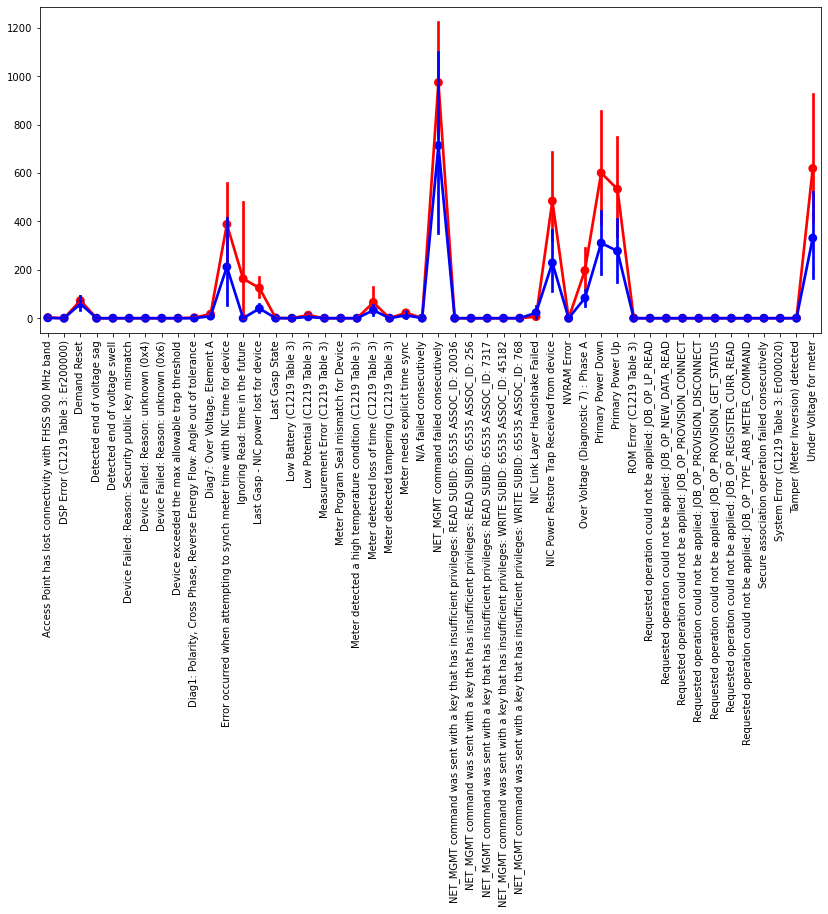

In [89]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_full.loc['2021-01':'2021-12', '01-05 Days'], 
    color='red'
)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_no_outg.loc['2021-01':'2021-12', '01-05 Days'], 
    color='blue'
)
Plot_General.rotate_ticklabels(axs, 90)

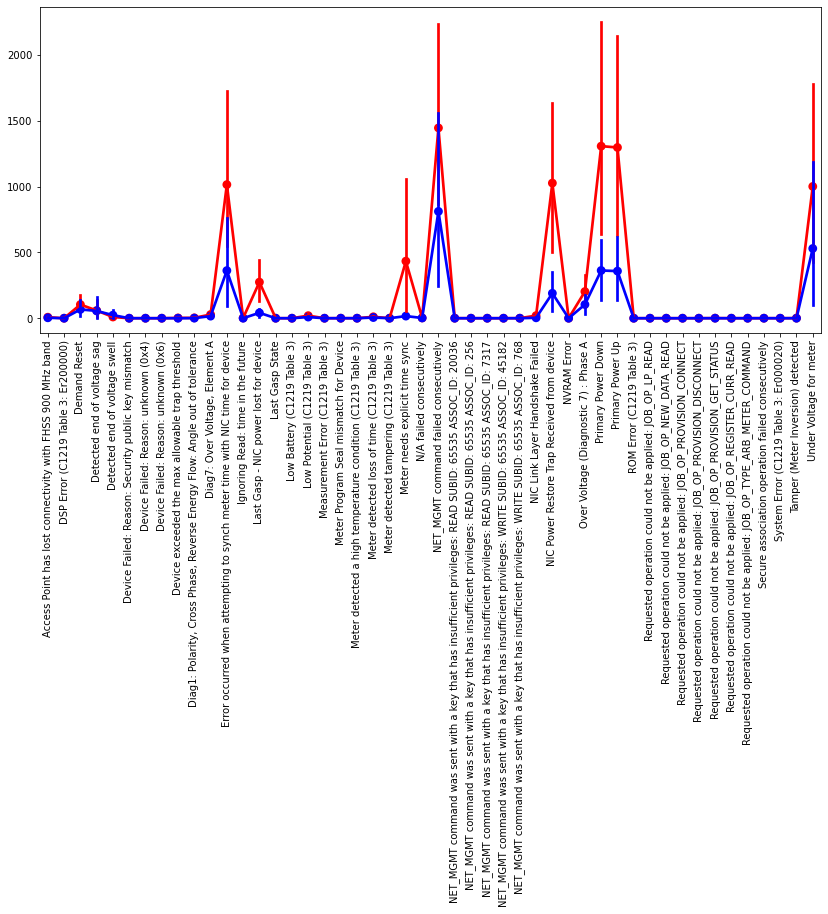

In [90]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_full.loc['2022-01':'2022-12', '01-05 Days'], 
    color='red'
)
sns.pointplot(
    ax=axs, 
    data=reason_sums_by_monthyear_no_outg.loc['2022-01':'2022-12', '01-05 Days'], 
    color='blue'
)
Plot_General.rotate_ticklabels(axs, 90)

In [103]:
reason_sums_by_monthyear_full.shape[0]

33

In [107]:
reason_sums_by_monthyear_full.index.tolist()

['2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '2020-12',
 '2021-01',
 '2021-02',
 '2021-03',
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06',
 '2022-07',
 '2022-08',
 '2022-09']

In [110]:
len(reason_sums_by_monthyear_no_outg.index.tolist())

28

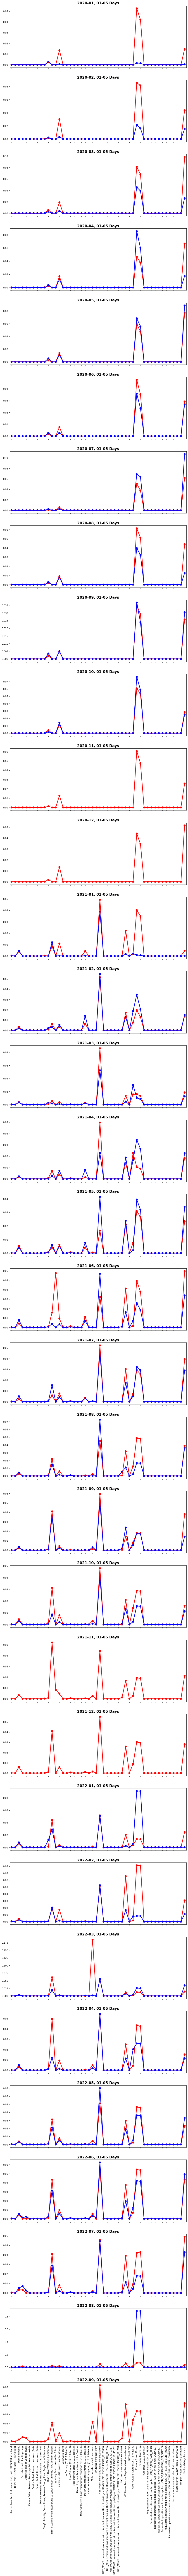

In [116]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=reason_sums_by_monthyear_full.shape[0], fig_num=1, sharex='col')
for i_plot in range(reason_sums_by_monthyear_full.shape[0]):
    idx_i = reason_sums_by_monthyear_full.index.tolist()[i_plot]
    if idx_i in reason_sums_by_monthyear_full.index.tolist():
        sns.pointplot(
            ax=axs[i_plot], 
            data=reason_sums_by_monthyear_full.loc[[idx_i], '01-05 Days'], 
            color='red'
        )
    if idx_i in reason_sums_by_monthyear_no_outg.index.tolist():
        sns.pointplot(
            ax=axs[i_plot], 
            data=reason_sums_by_monthyear_no_outg.loc[[idx_i], '01-05 Days'], 
            color='blue'
        )
    Plot_General.set_general_plotting_args(
        axs[i_plot], 
        title_args=dict(label=f'{idx_i}, 01-05 Days', fontdict=dict(fontweight='semibold', fontsize=16)),  
        tick_args=dict(axis='x', labelrotation=90)
    )

In [ ]:
print(merged_df_full.shape)
print(merged_df_drct.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

In [ ]:
# include_only_stat_sig = False
# if include_only_stat_sig:
#     sig_reasons = get_stat_sig_reasons(merged_df_drct, merged_df_no_outg)
#     merged_df_drct, merged_df_no_outg = project_stat_sig_reasons(merged_df_drct, merged_df_no_outg)

In [ ]:
print(merged_df_full.shape)
print(merged_df_drct.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

In [ ]:
merged_df_full=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_full)
merged_df_drct=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_drct)
merged_df_no_outg=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg)
merged_df_no_outg_prstn=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg_prstn)

In [ ]:
print(merged_df_full.shape)
print(merged_df_drct.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

In [ ]:
assert(len(set(merged_df_full.index).difference(set(counts_series_full.index)))==0)
assert(len(set(merged_df_drct.index).difference(set(counts_series_drct.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(counts_series_no_outg.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(counts_series_no_outg_prstn.index)))==0)

merged_df_full = pd.merge(
    merged_df_full, 
    counts_series_full.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_drct = pd.merge(
    merged_df_drct, 
    counts_series_drct.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    counts_series_no_outg.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    counts_series_no_outg_prstn.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

In [ ]:
print(merged_df_full.shape)
print(merged_df_drct.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

In [ ]:
merged_df_full

In [ ]:
print(merged_df_drct.shape)
print(merged_df_drct.index.get_level_values(0).nunique())
print(merged_df_drct.index.get_level_values(1).nunique())

In [ ]:
merged_df_drct.index.get_level_values(1).value_counts()

In [ ]:
merged_df_drct['01-05 Days']

In [ ]:
merged_df_drct

# =========================================================
# =========================================================

# EEMSP

In [ ]:
merge_eemsp = False
build_eemsp = False

In [ ]:
if merge_eemsp:
    trsf_pole_nbs = list(set(
        merged_df_drct.index.get_level_values(1).unique().tolist()+
        merged_df_full.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg_prstn.index.get_level_values(1).unique().tolist()
    ))

In [ ]:
if merge_eemsp:
    if build_eemsp:
        conn_eemsp = Utilities.get_eemsp_oracle_connection()
        df_eemsp_OG = build_df_eemsp(conn_eemsp, trsf_pole_nbs, batch_size=1000, verbose=True, n_update=10)
        df_eemsp_OG.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    else:
        df_eemsp_OG = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))

In [ ]:
if merge_eemsp:
    df_eemsp = df_eemsp_OG.copy()
    print(df_eemsp.shape)
    print(df_eemsp.columns)

In [ ]:
if merge_eemsp:
    # TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Currently, simply taking the first entry wrt LOCATION_NB
    df_eemsp = df_eemsp.sort_values(by=['LOCATION_NB', 'INSTALL_DT'], ignore_index=True)
    df_eemsp = df_eemsp.groupby('LOCATION_NB', as_index=False).first()

In [ ]:
if merge_eemsp:
    cols_of_interest_eemsp = [
        'LOCATION_NB', 
        'MFGR_NM', 
        'INSTALL_DT', 
        'LAST_TRANS_DESC', 
        'EQTYPE_ID', 
        'COOLANT', 
        'INFO', 
        'KVA_SIZE',
        'PHASE_CNT', 
        'PRIM_VOLTAGE', 
        'PROTECTION', 
        'PRU_NUMBER', 
        'SEC_VOLTAGE', 
        'SPECIAL_CHAR', 
        'TAPS', 
        'XFTYPE'
    ]
    # df_eemsp=df_eemsp[df_eemsp['REMOVAL_DT'].isna()]
    df_eemsp=df_eemsp[cols_of_interest_eemsp]

In [ ]:
if merge_eemsp:
    assert(df_eemsp.shape[0]==df_eemsp['LOCATION_NB'].nunique())
    print(f"df_eemsp.shape[0]                 = {df_eemsp.shape[0]}")
    print(f"len(trsf_pole_nbs)                = {len(trsf_pole_nbs)}")
    print(f"Diff                              = {len(trsf_pole_nbs)-df_eemsp.shape[0]}")

In [ ]:
if merge_eemsp:
    #-------------------------
    print(f"merged_df_drct.shape          = {merged_df_drct.shape}")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")
    #-------------------------
    df_eemsp = Utilities_df.prepend_level_to_MultiIndex(df_eemsp, level_val='EEMSP', axis=1)
    #-------------------------
    merged_df_drct = pd.merge(
        merged_df_drct, 
        df_eemsp.set_index(('EEMSP', 'LOCATION_NB')), 
        left_on=merged_df_drct.index.get_level_values(1), 
        right_index=True, 
        how='inner'
    )
    #-------------------------
    merged_df_full = pd.merge(
        merged_df_full, 
        df_eemsp.set_index(('EEMSP', 'LOCATION_NB')), 
        left_on=merged_df_full.index.get_level_values(1), 
        right_index=True, 
        how='inner'
    )
    #-------------------------
    merged_df_no_outg = pd.merge(
        merged_df_no_outg, 
        df_eemsp.set_index(('EEMSP', 'LOCATION_NB')), 
        left_on=merged_df_no_outg.index.get_level_values(1), 
        right_index=True, 
        how='inner'
    )
    #-------------------------
    merged_df_no_outg_prstn = pd.merge(
        merged_df_no_outg_prstn, 
        df_eemsp.set_index(('EEMSP', 'LOCATION_NB')), 
        left_on=merged_df_no_outg_prstn.index.get_level_values(1), 
        right_index=True, 
        how='inner'
    )
    #-------------------------
    print()
    print(f"merged_df_drct.shape          = {merged_df_drct.shape}")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")

In [ ]:
# REMOVING SCHEDULED OUTAGES

print(f'merged_df_full.shape = {merged_df_full.shape}')
print(f'merged_df_drct.shape = {merged_df_drct.shape}')

merged_df_full =  MECPODf.get_cpo_df_subset_excluding_mjr_mnr_causes( 
    cpo_df=merged_df_full, 
    mjr_mnr_causes_to_exclude=None, 
    mjr_causes_to_exclude=None,
    mnr_causes_to_exclude=['SCO', 'SO'], 
    outg_rec_nb_col='index'
)

merged_df_drct =  MECPODf.get_cpo_df_subset_excluding_mjr_mnr_causes( 
    cpo_df=merged_df_drct, 
    mjr_mnr_causes_to_exclude=None, 
    mjr_causes_to_exclude=None,
    mnr_causes_to_exclude=['SCO', 'SO'], 
    outg_rec_nb_col='index'
)

print(f'merged_df_full.shape = {merged_df_full.shape}')
print(f'merged_df_drct.shape = {merged_df_drct.shape}')

In [ ]:
merged_df_drct.index.get_level_values(0).nunique()

In [ ]:
merged_df_drct

# !~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~

In [ ]:
# Remove NETWORK and PRIMARY trsf_pole_nbs
# merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
# merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
#-----
merged_df_full=merged_df_full[~merged_df_full.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
merged_df_drct=merged_df_drct[~merged_df_drct.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]

In [ ]:
# Get DOVS info to be used for setting target values
merged_df_full_w_DOVS = DOVSOutages.append_outg_info_to_df(
    df=merged_df_full.copy(), 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)
merged_df_full_w_DOVS=merged_df_full_w_DOVS[['outg_dummy_lvl_0']]
merged_df_full_w_DOVS[('is_outg', 'is_outg')]=0

In [ ]:
# Add 'from_outg' information so I can track how many are in target=1 and target=0 
merged_df_full[('from_outg', 'from_outg')]          = 1
merged_df_no_outg[('from_outg', 'from_outg')]       = 0
merged_df_no_outg_prstn[('from_outg', 'from_outg')] = 0

In [ ]:
build_no_outg_time_infos_dfs=False
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\Models'


if build_no_outg_time_infos_dfs:
    ede_data_dir_no_outg_2020 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20200101_20201231\EndEvents_NoOutg'
    ede_data_dir_no_outg_2021 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20210101_20211231\EndEvents_NoOutg'
    ede_data_dir_no_outg_2022 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20220101_20220930\EndEvents_NoOutg'
    #-------------------------
    no_outg_time_infos_df_2020 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_2020)
    no_outg_time_infos_df_2021 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_2021)
    no_outg_time_infos_df_2022 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_2022)
    #-------------------------
    no_outg_time_infos_df = pd.concat([no_outg_time_infos_df_2020, no_outg_time_infos_df_2021, no_outg_time_infos_df_2022])
    #-------------------------
    no_outg_time_infos_df.to_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
else:
    no_outg_time_infos_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
#--------------------------------------------------    
#--------------------------------------------------    
if build_no_outg_time_infos_dfs:
#     ede_data_dir_no_outg_prstn_2020 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221014\20200101_20201231\EndEvents_NoOutg'
#     ede_data_dir_no_outg_prstn_2021 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221014\20210101_20211231\EndEvents_NoOutg'
#     ede_data_dir_no_outg_prstn_2022 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221014\20220101_20220930\EndEvents_NoOutg'
    ede_data_dir_no_outg_prstn_2020 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20200101_20201231\NoOutgs_Pristine\EndEvents'
    ede_data_dir_no_outg_prstn_2021 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20210101_20211231\NoOutgs_Pristine\EndEvents'
    ede_data_dir_no_outg_prstn_2022 = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20220101_20221231\NoOutgs_Pristine\EndEvents'
    #-------------------------
    no_outg_time_infos_df_prstn_2020 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_prstn_2020)
    no_outg_time_infos_df_prstn_2021 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_prstn_2021)
    no_outg_time_infos_df_prstn_2022 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_for_data_in_dir(ede_data_dir_no_outg_prstn_2022)
    #-------------------------
    no_outg_time_infos_prstn_df = pd.concat([no_outg_time_infos_df_prstn_2020, no_outg_time_infos_df_prstn_2021, no_outg_time_infos_df_prstn_2022])
    #-------------------------
    no_outg_time_infos_prstn_df.to_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))
else:
    no_outg_time_infos_prstn_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl')) 


In [ ]:
date_0_train   = pd.to_datetime('2020-01-01')
date_1_train   = pd.to_datetime('2022-01-01')
#-----
date_0_test    = pd.to_datetime('2022-01-01')
date_1_test    = pd.to_datetime('2022-06-01')
#-----
date_0_HOLDOUT = pd.to_datetime('2022-06-01')
date_1_HOLDOUT = pd.to_datetime('2023-01-01')

# date_0_train   = pd.to_datetime('2020-01-01')
# date_1_train   = pd.to_datetime('2022-01-01')
# #-----
# date_0_test    = pd.to_datetime('2022-01-01')
# date_1_test    = pd.to_datetime('2022-01-01')
# #-----
# date_0_HOLDOUT = pd.to_datetime('2022-01-01')
# date_1_HOLDOUT = pd.to_datetime('2023-01-01')

In [ ]:
get_train_test_by_date = False

In [ ]:
random_state = None
if get_train_test_by_date:
    merged_df_full_train = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    merged_df_full_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
else:
    merged_df_full_train_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    merged_df_full_train, merged_df_full_test = train_test_split(
        merged_df_full_train_test, 
        test_size=0.33, 
        random_state=random_state
    )
#-------------------------    
merged_df_full_HOLDOUT = get_cpx_outg_df_subset_by_outg_datetime(
    cpx_outg_df=merged_df_full.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    outg_rec_nb_idfr='index', 
    return_notin_also=False
)

In [ ]:
if get_train_test_by_date:
    merged_df_no_outg_train = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_train, merged_df_no_outg_test = train_test_split(
        merged_df_no_outg_train_test, 
        test_size=0.33, 
        random_state=random_state
    )
#-------------------------   
merged_df_no_outg_HOLDOUT = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg.copy(), 
    bsln_time_infos_df = no_outg_time_infos_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)
#--------------------------------------------------   
if get_train_test_by_date:
    merged_df_no_outg_prstn_train = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_prstn_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_prstn_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_prstn_train, merged_df_no_outg_prstn_test = train_test_split(
        merged_df_no_outg_prstn_train_test, 
        test_size=0.33, 
        random_state=random_state
    )
#-------------------------   
merged_df_no_outg_prstn_HOLDOUT = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
    bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)

In [ ]:
addtnl_baseline_train = pd.concat([merged_df_no_outg_train, merged_df_no_outg_prstn_train])
# addtnl_baseline_train = addtnl_baseline_train.sample(frac=0.10)

addtnl_baseline_test = pd.concat([merged_df_no_outg_test, merged_df_no_outg_prstn_test])
# addtnl_baseline_test = addtnl_baseline_test.sample(frac=0.10)

addtnl_baseline_HOLDOUT = pd.concat([merged_df_no_outg_HOLDOUT, merged_df_no_outg_prstn_HOLDOUT])
# addtnl_baseline_HOLDOUT = addtnl_baseline_HOLDOUT.sample(frac=0.10)

In [ ]:
full_data_df_train   = pd.concat([merged_df_full_train, addtnl_baseline_train])
full_data_df_test    = pd.concat([merged_df_full_test, addtnl_baseline_test])
full_data_df_HOLDOUT = pd.concat([merged_df_full_HOLDOUT, addtnl_baseline_HOLDOUT])

#Shuffle the data
full_data_df_train   = full_data_df_train.sample(frac=1)
full_data_df_test    = full_data_df_test.sample(frac=1)
full_data_df_HOLDOUT = full_data_df_HOLDOUT.sample(frac=1)

full_data_df = pd.concat([full_data_df_train, full_data_df_test, full_data_df_HOLDOUT])

# =========================================================
# =========================================================

In [ ]:
#NOTE!!!!!!!!!!!!!
# If using _v2, SHOULD NOT SCALE events_period column!!!!!!!!!!!!

create_validation_set = True
test_size = 0.33
val_size = 0.10 #w.r.t to train size (i.e., w.r.t 1.0-test_size)

run_scaler=True

run_PCA = False
pca_n_components=0.95

# random_state = 42
random_state = None

In [ ]:
if merge_eemsp:
    full_data_df_train   = full_data_df_train.drop(columns=[('key_0', '')])
    full_data_df_test    = full_data_df_test.drop(columns=[('key_0', '')])
    full_data_df_HOLDOUT = full_data_df_HOLDOUT.drop(columns=[('key_0', '')])
    
    le = preprocessing.LabelEncoder()
    cols_to_encode = full_data_df['EEMSP'].columns
    for col in cols_to_encode:
        le.fit(full_data_df[('EEMSP', col)])
        #-----
        full_data_df_train[('EEMSP', col)]   = le.transform(full_data_df_train[('EEMSP', col)])
        full_data_df_test[('EEMSP', col)]    = le.transform(full_data_df_test[('EEMSP', col)])
        full_data_df_HOLDOUT[('EEMSP', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP', col)])

# Set target values

In [ ]:
fig_save_dir_base = r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\ConfusionMatrices'
# fig_save_subdir = 'Target_eq_1_ALL_w_EEMSP'
fig_save_subdir = 'Target_eq_1_ALL'
# fig_save_subdir = 'trsf_nb_eq_LocID_w_EEMSP'
fig_save_dir = os.path.join(fig_save_dir_base, fig_save_subdir)

In [ ]:
merged_df_full_w_DOVS

In [ ]:
xfmr_equip_typ_nms_of_interest = ['TRANSFORMER, OH', 'TRANSFORMER, UG']
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
#             value=xfmr_equip_typ_nms_of_interest, 
#             comparison_operator='isin'
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'MNR_CAUSE_NM'), 
#             value='EQUIPMENT FAILURE', 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
slicer = DFSlicer()
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
#             value='CONDUCTOR OVERHEAD', 
#             comparison_operator='=='
#         )
#     ]
# )

In [ ]:
merged_df_full_w_DOVS_i = slicer.set_simple_column_value(df=merged_df_full_w_DOVS.copy(), column=('is_outg', 'is_outg'), value=1)
full_outg_idxs_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==1].index

In [ ]:
full_data_df_i         = full_data_df.copy()
full_data_df_train_i   = full_data_df_train.copy()
full_data_df_test_i    = full_data_df_test.copy()
full_data_df_HOLDOUT_i = full_data_df_HOLDOUT.copy()
#-------------------------
full_data_df_i[('is_outg', 'is_outg')]         = 0
full_data_df_train_i[('is_outg', 'is_outg')]   = 0
full_data_df_test_i[('is_outg', 'is_outg')]    = 0
full_data_df_HOLDOUT_i[('is_outg', 'is_outg')] = 0
#-------------------------
full_data_df_i.loc[set(full_data_df_i.index).intersection(set(full_outg_idxs_i)), ('is_outg', 'is_outg')]                 = 1
full_data_df_train_i.loc[set(full_data_df_train_i.index).intersection(set(full_outg_idxs_i)), ('is_outg', 'is_outg')]     = 1
full_data_df_test_i.loc[set(full_data_df_test_i.index).intersection(set(full_outg_idxs_i)), ('is_outg', 'is_outg')]       = 1
full_data_df_HOLDOUT_i.loc[set(full_data_df_HOLDOUT_i.index).intersection(set(full_outg_idxs_i)), ('is_outg', 'is_outg')] = 1
#-------------------------
full_data_df_i         = Utilities_df.move_cols_to_back(full_data_df_i, [('is_outg', 'is_outg')])
full_data_df_train_i   = Utilities_df.move_cols_to_back(full_data_df_train_i, [('is_outg', 'is_outg')])
full_data_df_test_i    = Utilities_df.move_cols_to_back(full_data_df_test_i, [('is_outg', 'is_outg')])
full_data_df_HOLDOUT_i = Utilities_df.move_cols_to_back(full_data_df_HOLDOUT_i, [('is_outg', 'is_outg')])

In [ ]:
#--------------------------------------------------
n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_train = full_data_df_train_i[
    (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_train_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
#-----
print('\n----- TRAIN -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
print(f"# additional baseline (target = 0): {n_bsln_train}")
print(f"%(target==1):                       {pct_target_1_train}%")

#--------------------------------------------------
n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_test = full_data_df_test_i[
    (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_test_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
#-----
print('\n----- TEST -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
print(f"# additional baseline (target = 0): {n_bsln_test}")
print(f"%(target==1):                       {pct_target_1_test}%")

#--------------------------------------------------
n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
    (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
#-----
print('\n----- HOLDOUT -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")

In [ ]:
if ('from_outg', 'from_outg') in full_data_df_train_i.columns.tolist():
    full_data_df_train_i = full_data_df_train_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_test_i.columns.tolist():
    full_data_df_test_i = full_data_df_test_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_HOLDOUT_i.columns.tolist():
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=[('from_outg', 'from_outg')])

# Prepare Data

In [ ]:
#-------------------------
X_train_OG = full_data_df_train_i.iloc[:, :-1].copy()
y_train    = full_data_df_train_i.iloc[:, -1].copy()

X_test_OG = full_data_df_test_i.iloc[:, :-1].copy()
y_test    = full_data_df_test_i.iloc[:, -1].copy()

X_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, :-1]
y_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, -1]

In [ ]:
fig, axs = Plot_General.default_subplots(2,2, return_flattened_axes=True)
#-------------------------
sns.countplot(ax=axs[0], x = ('is_outg', 'is_outg'), data=full_data_df_i)
axs[0].set_title('Full Data');
axs[0].set_xlabel('Is Outage');
axs[0].set_ylim([1.05*x for x in axs[0].get_ylim()])
for p in axs[0].patches:
    pct = (p.get_height()/full_data_df_i.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[0].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[1], x = ('is_outg', 'is_outg'), data=y_train.to_frame())
axs[1].set_title('Training Data');
axs[1].set_xlabel('Is Outage');
axs[1].set_ylim([1.05*x for x in axs[1].get_ylim()])
for p in axs[1].patches:
    pct = (p.get_height()/y_train.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[1].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[2], x = ('is_outg', 'is_outg'), data=y_test.to_frame())
axs[2].set_title('Testing Data');
axs[2].set_xlabel('Is Outage');
axs[2].set_ylim([1.05*x for x in axs[2].get_ylim()])
for p in axs[2].patches:
    pct = (p.get_height()/y_test.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[2].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[3], x = ('is_outg', 'is_outg'), data=y_HOLDOUT.to_frame())
axs[3].set_title('Holdout Data');
axs[3].set_xlabel('Is Outage');
axs[3].set_ylim([1.05*x for x in axs[3].get_ylim()])
for p in axs[3].patches:
    pct = (p.get_height()/y_HOLDOUT.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[3].text(txt_x,txt_y,txt)

In [ ]:
#-------------------------
if create_validation_set:
    X_train_OG, X_val_OG, y_train, y_val = train_test_split(X_train_OG, y_train, test_size=val_size, random_state=random_state)
#-------------------------
if run_scaler:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_OG)
    #-----
    X_val   = scaler.transform(X_val_OG)
    X_test  = scaler.transform(X_test_OG)
    X_HOLDOUT   = scaler.transform(X_HOLDOUT)
else:
    X_train = X_train_OG
    X_val   = X_val_OG
    X_test  = X_test_OG

In [ ]:
if run_PCA:
    # First, generate a PCA plot, showing the explained variance on the y-axis and number of components on x
    # This is simply to check that the number of components kept looks correct
    pca = PCA()
    pca.fit(X_train)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cumsum)
    
    # Now, run the PCA with pca_n_components and perform transforms
    pca=PCA(n_components=pca_n_components)
    X_train = pca.fit_transform(X_train)
    print(f'PCA n-components       = {pca.n_components_}')
    print(f'PCA explained variance = {pca.explained_variance_ratio_.sum()}')
    #-----
    X_val      = pca.transform(X_val)
    X_test     = pca.transform(X_test)
    X_HOLDOUT  = pca.transform(X_HOLDOUT)

# Dumb Classifier

In [ ]:
dumb_clf = DumbClassifier()
cross_val_score(dumb_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# y_pred = dumb_clf.predict(X_test)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
# print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
# print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
# confusion_matrix(y_test, y_pred)

# Random Forest

In [ ]:
# forest_clf = RandomForestClassifier(n_estimators = 100)
# forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
# forest_clf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', n_jobs=-1)

# forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=-1)
forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None)
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=None, n_jobs=None)

In [ ]:
start = time.time()
forest_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
y_pred_train = forest_clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print()

y_pred = forest_clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print()

y_pred_HOLDOUT = forest_clf.predict(X_HOLDOUT)
print('*****'*5)
print('HOLDOOUT DATASET')
print('*****'*5)
print(f"#(target==1): {y_HOLDOUT.sum()}")
print(f"#(target==0): {y_HOLDOUT.shape[0]-y_HOLDOUT.sum()}")
print(f"%(target==1): {100*(y_HOLDOUT.sum()/(y_HOLDOUT.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))

In [ ]:
save_figs = False

In [ ]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_pred_train, normalize=None), 
    display_labels=['No Outg.','Outage']
)
cmd.plot(values_format='.3e')
# cmd.plot(values_format='')
# cmd.ax_.set(xlabel='Predicted', ylabel='True')
cmd.ax_.set_xlabel('Predicted', fontsize=16)
cmd.ax_.set_ylabel('True', fontsize=16)
cmd.ax_.set_title('Train', fontsize=20, fontweight='semibold')
# cmd.figure_.set_size_inches(12, 10)

cmd.figure_.text(1.0, 0.9, "# Entries:    {:.4e}".format(y_train.shape[0]), fontsize=14)
cmd.figure_.text(1.0, 0.8, "# Outages:  {:.4e}".format(y_train.sum()), fontsize=14)
cmd.figure_.text(1.0, 0.7, "# Baseline:  {:.4e}".format(y_train.shape[0]-y_train.sum()), fontsize=14)
cmd.figure_.text(1.0, 0.6, "% Outages:  {:.4f}".format(100*y_train.sum()/y_train.shape[0]), fontsize=14)


cmd.figure_.text(1.0, 0.4, "ACCURACY:  {:.4f}".format(accuracy_score(y_train, y_pred_train)), fontsize=14)
cmd.figure_.text(1.0, 0.3, "PRECISION:  {:.4f}".format(precision_score(y_train, y_pred_train)), fontsize=14)
cmd.figure_.text(1.0, 0.2, "RECALL:       {:.4f}".format(recall_score(y_train, y_pred_train)), fontsize=14)

if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=cmd.figure_, 
        save_dir=fig_save_dir, 
        save_name='ConfusionMatrix_Train.png', 
        bbox_inches='tight'
    )

In [ ]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize=None), 
    display_labels=['No Outg.','Outage']
)
cmd.plot(values_format='.3e')
# cmd.plot(values_format='')
# cmd.ax_.set(xlabel='Predicted', ylabel='True')
cmd.ax_.set_xlabel('Predicted', fontsize=16)
cmd.ax_.set_ylabel('True', fontsize=16)
cmd.ax_.set_title('Test', fontsize=20, fontweight='semibold')
# cmd.figure_.set_size_inches(12, 10)

cmd.figure_.text(1.0, 0.9, "# Entries:    {:.4e}".format(y_test.shape[0]), fontsize=14)
cmd.figure_.text(1.0, 0.8, "# Outages:  {:.4e}".format(y_test.sum()), fontsize=14)
cmd.figure_.text(1.0, 0.7, "# Baseline:  {:.4e}".format(y_test.shape[0]-y_test.sum()), fontsize=14)
cmd.figure_.text(1.0, 0.6, "% Outages:  {:.4f}".format(100*y_test.sum()/y_test.shape[0]), fontsize=14)

cmd.figure_.text(1.0, 0.4, "ACCURACY:  {:.4f}".format(accuracy_score(y_test, y_pred)), fontsize=14)
cmd.figure_.text(1.0, 0.3, "PRECISION:  {:.4f}".format(precision_score(y_test, y_pred)), fontsize=14)
cmd.figure_.text(1.0, 0.2, "RECALL:       {:.4f}".format(recall_score(y_test, y_pred)), fontsize=14)

if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=cmd.figure_, 
        save_dir=fig_save_dir, 
        save_name='ConfusionMatrix_Test.png', 
        bbox_inches='tight'
    )

In [ ]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_HOLDOUT, y_pred_HOLDOUT, normalize=None), 
    display_labels=['No Outg.','Outage']
)
cmd.plot(values_format='.3e')
# cmd.plot(values_format='')
# cmd.ax_.set(xlabel='Predicted', ylabel='True')
cmd.ax_.set_xlabel('Predicted', fontsize=16)
cmd.ax_.set_ylabel('True', fontsize=16)
cmd.ax_.set_title('Holdout', fontsize=20, fontweight='semibold')
# cmd.figure_.set_size_inches(12, 10)

cmd.figure_.text(1.0, 0.9, "# Entries:    {:.4e}".format(y_HOLDOUT.shape[0]), fontsize=14)
cmd.figure_.text(1.0, 0.8, "# Outages:  {:.4e}".format(y_HOLDOUT.sum()), fontsize=14)
cmd.figure_.text(1.0, 0.7, "# Baseline:  {:.4e}".format(y_HOLDOUT.shape[0]-y_HOLDOUT.sum()), fontsize=14)
cmd.figure_.text(1.0, 0.6, "% Outages:  {:.4f}".format(100*y_HOLDOUT.sum()/y_HOLDOUT.shape[0]), fontsize=14)

cmd.figure_.text(1.0, 0.4, "ACCURACY:  {:.4f}".format(accuracy_score(y_HOLDOUT, y_pred_HOLDOUT)), fontsize=14)
cmd.figure_.text(1.0, 0.3, "PRECISION:  {:.4f}".format(precision_score(y_HOLDOUT, y_pred_HOLDOUT)), fontsize=14)
cmd.figure_.text(1.0, 0.2, "RECALL:       {:.4f}".format(recall_score(y_HOLDOUT, y_pred_HOLDOUT)), fontsize=14)

if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=cmd.figure_, 
        save_dir=fig_save_dir, 
        save_name='ConfusionMatrix_Holdout.png', 
        bbox_inches='tight'
    )

In [ ]:
# assert(0)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred, normalize='true')

In [ ]:
confusion_matrix(y_test, y_pred, normalize='pred')

In [ ]:
confusion_matrix(y_test, y_pred, normalize='all')

In [ ]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize=None), 
    display_labels=['No Outg.','Outage']
)
cmd.plot()
# cmd.ax_.set(xlabel='Predicted', ylabel='True')
cmd.ax_.set_xlabel('Predicted', fontsize=16)
cmd.ax_.set_ylabel('True', fontsize=16)

In [ ]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize='pred'), 
    display_labels=['No Outg.','Outage']
)
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [ ]:
importances = list(zip(full_data_df.columns, forest_clf.feature_importances_))
# importances

In [ ]:
importances_srtd = sorted(importances, key=lambda x: x[1], reverse=True)
importances_srtd[:10]

In [ ]:
importances_srtd

In [ ]:
pd.DataFrame(importances_srtd)

In [ ]:
for reason, importance in importances_srtd:
    print(f"{reason}:\t{importance}")

In [ ]:
def build_latex_rf_importances_table(
    importances_srtd, 
    n_round=10, 
    periods = [    
        '01-05 Days',
        '06-10 Days',
        '11-15 Days',
        '16-20 Days',
        '21-25 Days',
        '26-30 Days'
    ], 
    save_path=None
):
    #-------------------------
    latex_head = ['Period', 'Reason', 'Importance']
    latex = r"""
    \begin{longtable}{|c|c|c|}
      \hline
    """
    latex += "  " + ' & '.join(latex_head) + r'\\' + '\n' + r'  \hline' + '\n'
    #-------------------------
    for col_i, importance_i in importances_srtd:
        #----------
        if col_i[0] in periods:
            period_i=col_i[0]
        else:
            period_i=''
        #----------
        reason_i = col_i[1]
        #----------
        latex += r"  {period_i} & {reason_i} & {importance_i:.{n_round}e}\\".format(
            period_i=period_i, reason_i=reason_i, importance_i=importance_i, n_round=n_round
        )
        latex += '\n' + r'  \hline' + '\n'
    #-------------------------
    latex += r"\end{longtable}"
    #-------------------------
    if save_path:
        with open(save_path, 'w') as f:
            f.write(latex)
    #-------------------------
    return latex

In [ ]:
latex = build_latex_rf_importances_table(
    importances_srtd, 
    save_path=r'C:\Users\s346557\Downloads\test_latex.txt'
)

In [ ]:
# forest_clf.estimators_
est_depths = [estimator.get_depth() for estimator in forest_clf.estimators_]

In [ ]:
print(sorted(est_depths, reverse=False)[0])
print(sorted(est_depths, reverse=True)[0])

In [ ]:
forest_clf = RandomForestClassifier()

# # NOTE: Can be a single dict, or a list of dicts
forest_param_grid = { 
    'n_estimators': [100, 200, 500, 1000, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 20, 30, 40, 50],
    'criterion' :['gini', 'entropy', 'log_loss'], 
    'bootstrap':[True,False]
}

# # forest_param_grid = { 
# #     'n_estimators': [500, 1000],
# #     'max_features': ['auto', 'sqrt', 'log2'],
# #     'bootstrap':[True,False]
# # }

# # forest_grid_search = GridSearchCV(
# #     forest_clf, forest_param_grid, cv=3, 
# #     scoring=None, 
# #     return_train_score=True
# # )

forest_grid_search = RandomizedSearchCV(
    forest_clf, forest_param_grid, cv=3, 
    scoring=None, 
    return_train_score=True, 
    verbose=2
)

start = time.time()
forest_grid_search.fit(X_train, y_train)
print(time.time()-start)

print(forest_grid_search.best_params_)
print(forest_grid_search.best_estimator_)
y_pred = forest_grid_search.best_estimator_.predict(X_test)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
[int(x) for x in np.linspace(10, 50, num = 5)]

In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# #-------------------------
# # Create the random grid
# forest_param_grid = {
#     'n_estimators': n_estimators,
#     'max_features': max_features,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf,
#     'bootstrap': bootstrap
# }

# forest_grid_search = RandomizedSearchCV(
#     forest_clf, forest_param_grid, cv=3, 
#     scoring=None, 
#     return_train_score=True
# )
# #-------------------------
# start = time.time()
# forest_grid_search.fit(X_train, y_train)
# print(time.time()-start)

# print(forest_grid_search.best_params_)
# print(forest_grid_search.best_estimator_)
# y_pred = forest_grid_search.best_estimator_.predict(X_test)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
# print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
# print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
X_test

In [ ]:
if run_scaler:
    assert((scaler.transform(full_data_df_test.iloc[:, :-1])==X_test).all())
else:
    assert(full_data_df_test.iloc[:, :-1].equals(X_test))

In [ ]:
full_data_df_test[('is_outg', 'is_outg')].equals(y_test)

In [ ]:
X_by_confusion_result = get_X_entries_by_binary_confusion_matrix_result(X_test, y_test, y_pred)
X_by_confusion_result = convert_X_by_confusion_results_to_dfs(
    X_by_confusion_result=X_by_confusion_result, 
    full_data_df=full_data_df, 
    run_PCA=run_PCA, 
    run_scaler=run_scaler    
)

X_tp = X_by_confusion_result['X_tp']
X_tn = X_by_confusion_result['X_tn']
X_fp = X_by_confusion_result['X_fp']
X_fn = X_by_confusion_result['X_fn']

In [ ]:
X_tp

In [ ]:
# FUCK 

In [ ]:
y_pred

In [ ]:
full_data_df_test[('y_pred', 'y_pred')] = y_pred

In [ ]:
full_data_df_test

In [ ]:
full_data_df_test_tp = full_data_df_test[
    (full_data_df_test[('is_outg', 'is_outg')]==1) & 
    (full_data_df_test[('y_pred', 'y_pred')]==1)
]

full_data_df_test_tn = full_data_df_test[
    (full_data_df_test[('is_outg', 'is_outg')]==0) & 
    (full_data_df_test[('y_pred', 'y_pred')]==0)
]

full_data_df_test_fp = full_data_df_test[
    (full_data_df_test[('is_outg', 'is_outg')]==0) & 
    (full_data_df_test[('y_pred', 'y_pred')]==1)
]

full_data_df_test_fn = full_data_df_test[
    (full_data_df_test[('is_outg', 'is_outg')]==1) & 
    (full_data_df_test[('y_pred', 'y_pred')]==0)
]

In [ ]:
full_data_df_test_tp = DOVSOutages.append_outg_info_to_df(
    df=full_data_df_test_tp, 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)

In [ ]:
full_data_df_test_fn = DOVSOutages.append_outg_info_to_df(
    df=full_data_df_test_fn, 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)

In [ ]:
full_data_df_test_tp

In [ ]:
# NOTE: Need to drop duplicates so that outages are not weighted by
#       the number of transformers in outage
#--------------------------------------------------
#--------------------------------------------------
dovs_df_test_tp = full_data_df_test_tp['outg_dummy_lvl_0'].copy()
#-----
dovs_df_test_tp=dovs_df_test_tp.reset_index()
n_xfmr_per_outg_tp = dovs_df_test_tp[['outg_rec_nb', 'trsf_pole_nb']].groupby('outg_rec_nb').size()
n_xfmr_per_outg_tp.name = 'n_xfmrs_in_outg'
#-----
dovs_df_test_tp=dovs_df_test_tp.drop(columns=['trsf_pole_nb']).drop_duplicates().set_index('outg_rec_nb')
assert(dovs_df_test_tp.shape[0]==n_xfmr_per_outg_tp.shape[0])
og_len = dovs_df_test_tp.shape[0]
dovs_df_test_tp = pd.merge(dovs_df_test_tp, n_xfmr_per_outg_tp, left_index=True, right_index=True, how='inner')
assert(dovs_df_test_tp.shape[0]==og_len)
#--------------------------------------------------
#--------------------------------------------------
dovs_df_test_fn = full_data_df_test_fn['outg_dummy_lvl_0'].copy()
#-----
dovs_df_test_fn=dovs_df_test_fn.reset_index()
n_xfmr_per_outg_fn = dovs_df_test_fn[['outg_rec_nb', 'trsf_pole_nb']].groupby('outg_rec_nb').size()
n_xfmr_per_outg_fn.name = 'n_xfmrs_in_outg'
#-----
dovs_df_test_fn=dovs_df_test_fn.drop(columns=['trsf_pole_nb']).drop_duplicates().set_index('outg_rec_nb')
assert(dovs_df_test_fn.shape[0]==n_xfmr_per_outg_fn.shape[0])
og_len = dovs_df_test_fn.shape[0]
dovs_df_test_fn = pd.merge(dovs_df_test_fn, n_xfmr_per_outg_fn, left_index=True, right_index=True, how='inner')
assert(dovs_df_test_fn.shape[0]==og_len)

In [ ]:
dovs_df_test_tp_tmp = dovs_df_test_tp.copy()
dovs_df_test_fn_tmp = dovs_df_test_fn.copy()
#-----
dovs_df_test_tp_tmp['Cnfsn']='TP'
dovs_df_test_fn_tmp['Cnfsn']='FN'
#-----
dovs_df_test_tp_fn = pd.concat([dovs_df_test_tp_tmp, dovs_df_test_fn_tmp])
del dovs_df_test_tp_tmp
del dovs_df_test_fn_tmp

In [ ]:
dovs_df_test_tp_fn = DOVSOutages.set_mjr_mnr_cause_nm_col(
    dovs_df_test_tp_fn, 
    mjr_mnr_cause_nm_col='MJR_MNR_CAUSE_CD', 
    mjr_cause_nm_col='MJR_CAUSE_CD', 
    mnr_cause_nm_col='MNR_CAUSE_CD'
)
#-----
dovs_df_test_tp = DOVSOutages.set_mjr_mnr_cause_nm_col(
    dovs_df_test_tp, 
    mjr_mnr_cause_nm_col='MJR_MNR_CAUSE_CD', 
    mjr_cause_nm_col='MJR_CAUSE_CD', 
    mnr_cause_nm_col='MNR_CAUSE_CD'
)
#-----
dovs_df_test_fn = DOVSOutages.set_mjr_mnr_cause_nm_col(
    dovs_df_test_fn, 
    mjr_mnr_cause_nm_col='MJR_MNR_CAUSE_CD', 
    mjr_cause_nm_col='MJR_CAUSE_CD', 
    mnr_cause_nm_col='MNR_CAUSE_CD'
)

In [ ]:
def draw_dovs_boxplots_with_countplots(
    dovs_df,
    x_col,
    y_col,
    hue='Cnfsn', 
    order='avg_y', 
    batch_size=40,
    batch_absorb_last_pair_pct=0.50, 
    sharex=True, 
    fig_num=1, 
    hue_palette=dict(TP='green', FN='red'), 
    log_y_box=False,
    log_y_counts=False
):
    r"""
    order 
        Intent/in general: must be ['avg_y', 'counts_x'] or any in list + a hue value
            e.g., hue_vals are usually TP and FN, so one could set order='avg_y TP'
        However: User can supply own list of x_col values if, e.g., he wants his own custom ordering
            OR if he only wants to plot a subset of the values.
    """
    #--------------------------------------------------
    #--------------------------------------------------
    hue_vals = dovs_df[hue].unique().tolist()
    #-----
    assert(Utilities.is_object_one_of_types(order, [str, list]))
    if isinstance(order, str):
        accptbl_orders = ['avg_y', 'counts_x']
        accptbl_orders += [
            accptbl_order + f' {hue_val}' 
            for accptbl_order in accptbl_orders 
            for hue_val in hue_vals
        ]
        #-----
        assert(order in accptbl_orders)
        #-------------------------
        order_type_and_hue = re.findall(r"(avg_y|counts_x)\s?(.*)", order, flags=0)
        assert(len(order_type_and_hue)==1 and len(order_type_and_hue[0])==2)
        order_type, order_hue = order_type_and_hue[0]
        #-------------------------
        if order_hue:
            order_df = dovs_df[dovs_df[hue]==order_hue]
        else:
            order_df = dovs_df
        #-------------------------
        # Order by data in order_df, BUT need to ensure all values from dovs_df are included,
        #   hence the set operations.
        if order_type=='avg_y':
            order = order_df[[x_col, y_col]].groupby(x_col).mean().sort_values(by=y_col, ascending=False).index.tolist()
            order += list(set(dovs_df[[x_col, y_col]].groupby(x_col).mean().sort_values(by=y_col, ascending=False).index.tolist()).difference(order))
        elif order_type=='counts_x':
            order = order_df[x_col].value_counts().index.tolist()
            order += list(set(dovs_df[x_col].value_counts().index.tolist()).difference(order))
        else:
            assert(0)
        #   AND!!!!! NaN values are not caught by first set operation above, hence the need for the second below
        order += list(set(dovs_df[x_col].unique().tolist()).difference(order))
        #-------------------------
        assert(len(order)==dovs_df[x_col].nunique(dropna=False))
    #--------------------------------------------------
    #--------------------------------------------------
    if batch_size is None or batch_size==0:
        batch_idxs = [[0, len(order)]]
    else:
        batch_idxs = Utilities.get_batch_idx_pairs(
            n_total=len(order), 
            batch_size=batch_size, 
            absorb_last_pair_pct=batch_absorb_last_pair_pct
        )

    #----------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------
    if sharex==True:
        sharex='col'
    fig, axs = Plot_General.default_subplots(n_x=len(batch_idxs), n_y=2, fig_num=fig_num, return_flattened_axes=False, sharex=sharex)
    if axs.ndim==1:
        axs = np.expand_dims(axs, 1)
    #-------------------------
    for i_plot_col, (idx_0, idx_1) in enumerate(batch_idxs):
        sns.countplot(
            ax=axs[0][i_plot_col], 
            data=dovs_df,
            x=x_col, 
            hue=hue, 
            order=order[idx_0:idx_1], 
            palette=hue_palette
        )
        Plot_General.set_general_plotting_args(
            axs[0][i_plot_col], 
            draw_legend=True, 
            legend_args=dict(loc='upper right', fontsize=20), 
            title_args=dict(label=f'{x_col}s in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
            xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
            ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16)), 
            tick_args=dict(axis='x', labelrotation=90)
        )
        if log_y_counts:
            axs[0][i_plot_col].set_yscale('log')
        #-------------------------
        sns.boxplot(
            ax=axs[1][i_plot_col], 
            data=dovs_df,
            x=x_col, 
            y=y_col, 
            hue=hue, 
            order=order[idx_0:idx_1], 
            palette=hue_palette, 
            flierprops = dict(marker='x', markersize=3), 
            showmeans=True, 
            meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5)
        )
        Plot_General.set_general_plotting_args(
            axs[1][i_plot_col], 
            draw_legend=True, 
            legend_args=dict(loc='upper right', fontsize=20), 
            title_args=dict(label=f'{y_col} vs. {x_col} in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
            xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
            ylabel_args=dict(ylabel=y_col, loc='top', fontdict=dict(fontsize=16)), 
            tick_args=dict(axis='x', labelrotation=90)
        )
        if log_y_box:
            axs[1][i_plot_col].set_yscale('log')
    #-------------------------
    Plot_General.adjust_subplots_args(fig, dict(hspace=0.3))
    #----------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------
    return fig, axs

In [ ]:
def draw_dovs_cmi_ci_boxplots_with_countplots(
    dovs_df,
    x_col,
    hue='Cnfsn', 
    order='avg_y', 
    batch_size=40,
    batch_absorb_last_pair_pct=0.50, 
    sharex=True, 
    fig_num=1, 
    hue_palette=dict(TP='green', FN='red'), 
    log_y_box=False,
    log_y_counts=False
):
    r"""
    order 
        Intent/in general: must be ['avg_y', 'counts_x'] or any in list + a hue value
            e.g., hue_vals are usually TP and FN, so one could set order='avg_y TP'
        Order will be taken from CMI_NB (not CI_NB)...can be extended to both functionality later if needed
        However: User can supply own list of x_col values if, e.g., he wants his own custom ordering
            OR if he only wants to plot a subset of the values.
    """
    #--------------------------------------------------
    #--------------------------------------------------
    hue_vals = dovs_df[hue].unique().tolist()
    #-----
    assert(Utilities.is_object_one_of_types(order, [str, list]))
    if isinstance(order, str):
        accptbl_orders = ['avg_y', 'counts_x']
        accptbl_orders += [
            accptbl_order + f' {hue_val}' 
            for accptbl_order in accptbl_orders 
            for hue_val in hue_vals
        ]
        #-----
        assert(order in accptbl_orders)
        #-------------------------
        order_type_and_hue = re.findall(r"(avg_y|counts_x)\s?(.*)", order, flags=0)
        assert(len(order_type_and_hue)==1 and len(order_type_and_hue[0])==2)
        order_type, order_hue = order_type_and_hue[0]
        #-------------------------
        if order_hue:
            order_df = dovs_df[dovs_df[hue]==order_hue]
        else:
            order_df = dovs_df
        #-------------------------
        # Order by data in order_df, BUT need to ensure all values from dovs_df are included,
        #   hence the set operations.
        if order_type=='avg_y':
            order = order_df[[x_col, 'CMI_NB']].groupby(x_col).mean().sort_values(by='CMI_NB', ascending=False).index.tolist()
            order += list(set(dovs_df[[x_col, 'CMI_NB']].groupby(x_col).mean().sort_values(by='CMI_NB', ascending=False).index.tolist()).difference(order))
        elif order_type=='counts_x':
            order = order_df[x_col].value_counts().index.tolist()
            order += list(set(dovs_df[x_col].value_counts().index.tolist()).difference(order))
        else:
            assert(0)
        #   AND!!!!! NaN values are not caught by first set operation above, hence the need for the second below
        order += list(set(dovs_df[x_col].unique().tolist()).difference(order))
        #-------------------------
        assert(len(order)==dovs_df[x_col].nunique(dropna=False))
    #--------------------------------------------------
    #--------------------------------------------------
    if batch_size is None or batch_size==0:
        batch_idxs = [[0, len(order)]]
    else:
        batch_idxs = Utilities.get_batch_idx_pairs(
            n_total=len(order), 
            batch_size=batch_size, 
            absorb_last_pair_pct=batch_absorb_last_pair_pct
        )

    #----------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------
    if sharex==True:
        sharex='col'
    fig, axs = Plot_General.default_subplots(n_x=len(batch_idxs), n_y=3, fig_num=fig_num, return_flattened_axes=False, sharex=sharex)
    if axs.ndim==1:
        axs = np.expand_dims(axs, 1)
    #-------------------------
    for i_plot_col, (idx_0, idx_1) in enumerate(batch_idxs):
        sns.countplot(
            ax=axs[0][i_plot_col], 
            data=dovs_df,
            x=x_col, 
            hue=hue, 
            order=order[idx_0:idx_1], 
            palette=hue_palette
        )
        Plot_General.set_general_plotting_args(
            axs[0][i_plot_col], 
            draw_legend=True, 
            legend_args=dict(loc='upper right', fontsize=20), 
            title_args=dict(label=f'{x_col}s in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
            xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
            ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16)), 
            tick_args=dict(axis='x', labelrotation=90)
        )
        if log_y_counts:
            axs[0][i_plot_col].set_yscale('log')
        #-------------------------
        sns.boxplot(
            ax=axs[1][i_plot_col], 
            data=dovs_df,
            x=x_col, 
            y='CI_NB', 
            hue=hue, 
            order=order[idx_0:idx_1], 
            palette=hue_palette, 
            flierprops = dict(marker='x', markersize=3), 
            showmeans=True, 
            meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5)
        )
        Plot_General.set_general_plotting_args(
            axs[1][i_plot_col], 
            draw_legend=True, 
            legend_args=dict(loc='upper right', fontsize=20), 
            title_args=dict(label=f'CI_NB vs. {x_col} in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
            xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
            ylabel_args=dict(ylabel='CI_NB', loc='top', fontdict=dict(fontsize=16)), 
            tick_args=dict(axis='x', labelrotation=90)
        )
        if log_y_box:
            axs[1][i_plot_col].set_yscale('log')
        #-------------------------
        sns.boxplot(
            ax=axs[2][i_plot_col], 
            data=dovs_df,
            x=x_col, 
            y='CMI_NB', 
            hue=hue, 
            order=order[idx_0:idx_1], 
            palette=hue_palette, 
            flierprops = dict(marker='x', markersize=3), 
            showmeans=True, 
            meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5)
        )
        Plot_General.set_general_plotting_args(
            axs[2][i_plot_col], 
            draw_legend=True, 
            legend_args=dict(loc='upper right', fontsize=20), 
            title_args=dict(label=f'CMI_NB vs. {x_col} in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
            xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
            ylabel_args=dict(ylabel='CMI_NB', loc='top', fontdict=dict(fontsize=16)), 
            tick_args=dict(axis='x', labelrotation=90)
        )
        if log_y_box:
            axs[2][i_plot_col].set_yscale('log')
    #-------------------------
    Plot_General.adjust_subplots_args(fig, dict(hspace=0.3))
    #----------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------
    return fig, axs

In [ ]:
x_col = 'MNR_CAUSE_CD'
y_col = 'CI_NB'
#-----
# Order by data in dovs_df_test_tp, BUT need to ensure all values from dovs_df_test_tp_fn are included,
#   hence the set operation
order = dovs_df_test_tp[[x_col, y_col]].groupby(x_col).mean().sort_values(by=y_col, ascending=False).index.tolist()
order += list(set(dovs_df_test_tp_fn[x_col].unique().tolist()).difference(order))

fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.boxplot(
    ax=axs, 
    data=dovs_df_test_tp_fn,
    x=x_col, 
    y=y_col, 
    hue='Cnfsn', 
    order=order, 
    palette=dict(TP='green', FN='red'), 
    flierprops = dict(marker='x', markersize=3), 
    showmeans=True, 
    meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5)
);
Plot_General.set_general_plotting_args(
    axs, 
    draw_legend=True, 
    legend_args=dict(loc='upper right', fontsize=20), 
    title_args=dict(label=f'{y_col} vs. {x_col} in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel=y_col, loc='top', fontdict=dict(fontsize=16)), 
    tick_args=dict(axis='x', labelrotation=45)
)
axs.set_yscale('log')

In [ ]:
dovs_df_test_fn[dovs_df_test_fn['MNR_CAUSE_CD']=='FO'].describe()

In [ ]:
x_col = 'MNR_CAUSE_CD'
y_col = 'CI_NB'
#-----
# Order by data in dovs_df_test_tp, BUT need to ensure all values from dovs_df_test_tp_fn are included,
#   hence the set operation
order = dovs_df_test_tp[[x_col, y_col]].groupby(x_col).mean().sort_values(by=y_col, ascending=False).index.tolist()
order += list(set(dovs_df_test_tp_fn[x_col].unique().tolist()).difference(order))

fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
sns.pointplot(
    ax=axs, 
    data=dovs_df_test_tp_fn,
    x=x_col, 
    y=y_col, 
    hue='Cnfsn', 
    order=order, 
    palette=dict(TP='green', FN='red'), 
    dodge=0.5
);
Plot_General.set_general_plotting_args(
    axs, 
    draw_legend=True, 
    legend_args=dict(loc='upper right', fontsize=20), 
    title_args=dict(label=f'{y_col} vs. {x_col} in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel=y_col, loc='top', fontdict=dict(fontsize=16)), 
    tick_args=dict(axis='x', labelrotation=45)
)

In [ ]:
x_col = 'MNR_CAUSE_CD'
y_col = 'CI_NB'
#-----
# Order by data in dovs_df_test_tp, BUT need to ensure all values from dovs_df_test_tp_fn are included,
#   hence the set operation
order = dovs_df_test_tp[[x_col, y_col]].groupby(x_col).mean().sort_values(by=y_col, ascending=False).index.tolist()
order += list(set(dovs_df_test_tp_fn[x_col].unique().tolist()).difference(order))

fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
bplot = sns.boxplot(
    ax=axs, 
    data=dovs_df_test_tp_fn,
    x=x_col, 
    y=y_col, 
    hue='Cnfsn', 
    order=order, 
    palette=dict(TP='green', FN='red'), 
    flierprops = dict(marker='x', markersize=3), 
    showmeans=True, 
    meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5), 
    showfliers=False
);
children = axs.get_children()
sns.pointplot(
    ax=axs, 
    data=dovs_df_test_tp_fn,
    x=x_col, 
    y=y_col, 
    hue='Cnfsn', 
    order=order, 
    palette=dict(TP='green', FN='red'), 
    dodge=0.4, 
    join=True, 
    errorbar='ci', 
    capsize=0.2, 
    linestyles='dotted'
);

Plot_General.set_general_plotting_args(
    axs, 
    draw_legend=True, 
    legend_args=dict(loc='upper right', fontsize=20), 
    title_args=dict(label=f'{y_col} vs. {x_col} in Outages', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel=y_col, loc='top', fontdict=dict(fontsize=16)), 
    tick_args=dict(axis='x', labelrotation=45)
)

In [ ]:
dovs_df_test_fn[dovs_df_test_fn['MNR_CAUSE_CD']=='FO'].describe()

In [ ]:
bplot.get_children()

In [ ]:
bplot.

In [ ]:
idk = bplot.get_children()[0]

In [ ]:
bplot.get_children()[0].get_offsets()

In [ ]:
bplot.get_children()[1].get_offsets()

In [ ]:
idk.get_offsets()

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=None
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_box=True
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_box=False
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=None, 
    log_y_box=False
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=20, 
    log_y_box=False
)

In [ ]:
fig, axs = draw_dovs_cmi_ci_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=20, 
    log_y_box=False
)

In [ ]:
fig, axs = draw_dovs_cmi_ci_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    hue='Cnfsn', 
    order='counts_x', 
    sharex=True, 
    batch_size=40, 
    log_y_box=True, 
    log_y_counts=False
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y', 
    sharex=True, 
    batch_size=40
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='counts_x', 
    sharex=True, 
    log_y_box=True
)

In [ ]:
fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=None
)

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='counts_x', 
    sharex=True, 
    batch_size=40
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=False, 
    batch_size=40, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='DVC_TYP_NM',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='DVC_TYP_NM',
    y_col='CI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='EQUIP_TYP_NM',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='EQUIP_TYP_NM',
    y_col='CI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='MJR_MNR_CAUSE_CD',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=None, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
dovs_df_test_tp[dovs_df_test_tp['MJR_MNR_CAUSE_CD']=='DL-EQF']['CMI_NB']

In [ ]:
dovs_df_test_tp[dovs_df_test_tp['MJR_MNR_CAUSE_CD']=='DL-EQF']['CMI_NB'].describe()

In [ ]:
dovs_df_test_tp[dovs_df_test_tp['MJR_MNR_CAUSE_CD']=='DS-WU']['CMI_NB']

In [ ]:
dovs_df_test_tp[dovs_df_test_tp['MJR_MNR_CAUSE_CD']=='DS-WU']['CMI_NB'].describe()

In [ ]:
save_figs=False

fig, axs = draw_dovs_boxplots_with_countplots(
    dovs_df=dovs_df_test_tp_fn,
    x_col='EQUIP_TYP_NM',
    y_col='CMI_NB', 
    hue='Cnfsn', 
    order='avg_y TP', 
    sharex=True, 
    batch_size=40, 
    log_y_counts=True
)

#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'{y_col}_vs_{x_col}.png', 
        bbox_inches='tight'
    )

In [ ]:
save_figs=False

fig, axs = Plot_General.default_subplots(n_x=2, n_y=2, fig_num=1, return_flattened_axes=True, row_major=True)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[0],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CMI_NB', 
    min_max_and_bin_size=[0, 4e4, 4e4/25], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# CMI_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CMI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[1],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CMI_NB', 
    min_max_and_bin_size=[0, 2e6, 2e6/25], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# CMI_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CMI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
axs[1].set_yscale('log')
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[2],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CMI_NB', 
    min_max_and_bin_size=[0, 4e4, 4e4/25], 
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# CMI_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CMI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[3],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CMI_NB', 
    min_max_and_bin_size=[0, 2e6, 2e6/50], 
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# CMI_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CMI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
axs[3].set_yscale('log')
#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'CMI_NB_hist.png', 
        bbox_inches='tight'
    )

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=2, n_y=2, fig_num=1, return_flattened_axes=True, row_major=True)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[0],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CI_NB', 
    min_max_and_bin_size=[0, 5e2, 5e2/25],
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# CI_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[1],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CI_NB', 
    min_max_and_bin_size=[0, 5e3, 5e3/25], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# CI_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
axs[1].set_yscale('log')
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[2],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CI_NB', 
    min_max_and_bin_size=[0, 5e2, 5e2/25],
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# CI_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[3],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='CI_NB', 
    min_max_and_bin_size=[0, 5e3, 5e3/25], 
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# CI_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# CI_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
axs[3].set_yscale('log')
#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'CI_NB_hist.png', 
        bbox_inches='tight'
    )

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=2, n_y=2, fig_num=1, return_flattened_axes=True, row_major=True)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[0],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e2, 5e2/25],
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[1],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e3, 5e3/25], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
axs[1].set_yscale('log')
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[2],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e2, 5e2/25],
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[3],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e3, 5e3/25], 
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
axs[3].set_yscale('log')
#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'STEP_DRTN_NB_hist.png', 
        bbox_inches='tight'
    )

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=2, n_y=2, fig_num=1, return_flattened_axes=True, row_major=True)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[0],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')], 
        [dovs_df_test_tp_fn, dict(label='TP+FN', color='yellow')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e2, 5e2/25],
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[1],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')], 
        [dovs_df_test_tp_fn, dict(label='TP+FN', color='yellow')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e3, 5e3/25], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
axs[1].set_yscale('log')
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[2],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')], 
        [dovs_df_test_tp_fn, dict(label='TP+FN', color='yellow')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e2, 5e2/25],
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[3],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')], 
        [dovs_df_test_tp_fn, dict(label='TP+FN', color='yellow')]
    ],
    x_col='STEP_DRTN_NB', 
    min_max_and_bin_size=[0, 5e3, 5e3/25], 
    include_over_underflow=True, 
    stat='density', 
    draw_side_by_side=True, 
    title_args=dict(label='# STEP_DRTN_NB in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# STEP_DRTN_NB', loc='center', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
axs[3].set_yscale('log')

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
Plot_Hist.plot_multiple_hists(
    ax=axs,
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ], 
    x_col='n_xfmrs_in_outg', 
    min_max_and_bin_size=[0, 50, 50/10], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# Transformers in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# Transformers', loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
Plot_Hist.plot_multiple_hists(
    ax=axs,
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='n_xfmrs_in_outg', 
    min_max_and_bin_size=[0, 50, 50/10], 
    include_over_underflow=True, 
    stat='density',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# Transformers in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# Transformers', loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=2, fig_num=1, return_flattened_axes=True, row_major=True)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[0],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='n_xfmrs_in_outg', 
    min_max_and_bin_size=[0, 50, 50/25], 
    include_over_underflow=True, 
    stat='count',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# Transformers in Outage (counts)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# Transformers', loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
Plot_Hist.plot_multiple_hists(
    ax=axs[1],
    dfs_w_args=[
        [dovs_df_test_tp, dict(label='TP', color='green')], 
        [dovs_df_test_fn, dict(label='FN', color='red')]
    ],
    x_col='n_xfmrs_in_outg', 
    min_max_and_bin_size=[0, 50, 50/25], 
    include_over_underflow=True, 
    stat='density',
    draw_side_by_side=True, 
    draw_legend=True, 
    title_args=dict(label='# Transformers in Outage (density)', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel='# Transformers', loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Density', loc='top', fontdict=dict(fontsize=16))
)
#-------------------------
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name=f'n_xfmrs_in_outg_hist.png', 
        bbox_inches='tight'
    )

# EEMSP Plots

In [ ]:
full_data_df_test.head()

In [ ]:
df_eemsp_OG = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))

In [ ]:
df_eemsp = df_eemsp_OG.copy()
print(df_eemsp.shape)
print(df_eemsp.columns)

In [ ]:
# TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Currently, simply taking the first entry wrt LOCATION_NB
df_eemsp = df_eemsp.sort_values(by=['LOCATION_NB', 'INSTALL_DT'], ignore_index=True)
df_eemsp = df_eemsp.groupby('LOCATION_NB', as_index=False).first()

In [ ]:
cols_of_interest_eemsp = [
    'LOCATION_NB', 
    'MFGR_NM', 
    'INSTALL_DT', 
    'LAST_TRANS_DESC', 
    'EQTYPE_ID', 
    'COOLANT', 
    'INFO', 
    'KVA_SIZE',
    'PHASE_CNT', 
    'PRIM_VOLTAGE', 
    'PROTECTION', 
    'PRU_NUMBER', 
    'SEC_VOLTAGE', 
    'SPECIAL_CHAR', 
    'TAPS', 
    'XFTYPE'
]
# df_eemsp=df_eemsp[df_eemsp['REMOVAL_DT'].isna()]
df_eemsp=df_eemsp[cols_of_interest_eemsp]

In [ ]:
print(f"full_data_df_test.shape = {full_data_df_test.shape}")
#-------------------------
df_eemsp = Utilities_df.prepend_level_to_MultiIndex(df_eemsp, level_val='EEMSP', axis=1)
#-------------------------
full_data_df_test = pd.merge(
    full_data_df_test, 
    df_eemsp.set_index(('EEMSP', 'LOCATION_NB')), 
    left_on=full_data_df_test.index.get_level_values(1), 
    right_index=True, 
    how='inner'
)
#-------------------------
print(f"full_data_df_test.shape = {full_data_df_test.shape}")

In [ ]:
full_data_df_test[['is_outg', 'y_pred', 'EEMSP']]

In [ ]:
eemsp_df_test = full_data_df_test[['is_outg', 'y_pred', 'EEMSP']].copy()

In [ ]:
eemsp_df_test[('res_type', 'res_type')]=''

In [ ]:
eemsp_df_test.loc[
    (eemsp_df_test[('is_outg', 'is_outg')]==1) & 
    (eemsp_df_test[('y_pred', 'y_pred')]==1),
    ('res_type', 'res_type')
] = 'TP'
#-----
eemsp_df_test.loc[
    (eemsp_df_test[('is_outg', 'is_outg')]==0) & 
    (eemsp_df_test[('y_pred', 'y_pred')]==0),
    ('res_type', 'res_type')
] = 'TN'
#-----
eemsp_df_test.loc[
    (eemsp_df_test[('is_outg', 'is_outg')]==0) & 
    (eemsp_df_test[('y_pred', 'y_pred')]==1),
    ('res_type', 'res_type')
] = 'FP'
#-----
eemsp_df_test.loc[
    (eemsp_df_test[('is_outg', 'is_outg')]==1) & 
    (eemsp_df_test[('y_pred', 'y_pred')]==0),
    ('res_type', 'res_type')
] = 'FN'
#-----

In [ ]:
eemsp_df_test = eemsp_df_test[['EEMSP', 'res_type']].copy()
eemsp_df_test.columns = eemsp_df_test.columns.droplevel(0)

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# NOTE: In general, there will be duplicate entries for transformers!
#       One could remove the duplicates via, e.g., 
#         dev_eemsp_df_test.reset_index().drop(columns=['outg_rec_nb']).drop_duplicates()
#       However, duplicates would still remain due to a trsf_pole_nb having various res_types
#         (e.g., TP, FN, TN, FP)

In [ ]:
eemsp_df_test

In [ ]:
eemsp_df_test.columns

In [ ]:
x_col = 'KVA_SIZE'

fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
#-------------------------
sns.countplot(
    ax=axs, 
    data=eemsp_df_test,
    x=x_col, 
    hue='res_type', 
#     order=order[idx_0:idx_1], 
#     palette=dict(TP='green', FN='red')
    hue_order=['TP', 'FN', 'TN', 'FP']
)
Plot_General.set_general_plotting_args(
    axs, 
    draw_legend=True, 
    legend_args=dict(loc='upper right', fontsize=20), 
    title_args=dict(label=f'{x_col} for Result Types', fontdict=dict(fontweight='semibold', fontsize=16)), 
    xlabel_args=dict(xlabel=x_col, loc='right', fontdict=dict(fontsize=16)), 
    ylabel_args=dict(ylabel='Counts', loc='top', fontdict=dict(fontsize=16)), 
    tick_args=dict(axis='x', labelrotation=90)
)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
eemsp_df_test.groupby('res_type')['KVA_SIZE'].value_counts(normalize=True).rename('Whatev').reset_index().pipe((sns.barplot,'data'), x='KVA_SIZE',y='Whatev',hue='res_type',hue_order=['TP', 'FN', 'TN', 'FP'], ax=axs)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
eemsp_df_test.groupby('res_type')['KVA_SIZE'].value_counts(normalize=False).rename('Whatev').reset_index().pipe((sns.barplot,'data'), x='KVA_SIZE',y='Whatev',hue='res_type',hue_order=['TP', 'FN', 'TN', 'FP'], ax=axs)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
eemsp_df_test.groupby('res_type')['MFGR_NM'].value_counts(normalize=True).rename('Whatev').reset_index().pipe((sns.barplot,'data'), x='MFGR_NM',y='Whatev',hue='res_type',hue_order=['TP', 'FN', 'TN', 'FP'], ax=axs)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
eemsp_df_test.groupby('res_type')['MFGR_NM'].value_counts(normalize=False).rename('Whatev').reset_index().pipe((sns.barplot,'data'), x='MFGR_NM',y='Whatev',hue='res_type',hue_order=['TP', 'FN', 'TN', 'FP'], ax=axs)

In [ ]:
if run_PCA:
    # All Dfs should have same column order already, so don't matter which 
    #   is used below
    reason_order = X_tp.columns.tolist()
else:
    reason_order = [x[0] for x in importances_srtd]
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
Plot_Bar.plot_barplot(
    axs, 
    X_fn, 
    order=reason_order, 
    n_bars_to_include=10, 
    replace_xtick_labels_with_ints=True, 
    add_xtick_labels_legend_textbox=True, 
    fig=fig, 
    xtick_labels_legend_textbox_kwargs=dict(fontsize=10), 
    tick_args=[dict(axis='x', labelrotation=90, labelsize=15), 
               dict(axis='y', labelsize=15)]
)

In [ ]:
if run_PCA:
    # All Dfs should have same column order already, so don't matter which 
    #   is used below
    reason_order = X_tp.columns.tolist()
else:
    reason_order = [x[0] for x in importances_srtd]
fig, axs = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
Plot_Bar.plot_multiple_barplots(
    axs, 
    [
        (X_tp, dict(label='X_tp', color='green')), 
        (X_fn, dict(label='X_fn', edgecolor='green', fill=False, hatch='//')), 
        (X_tn, dict(label='X_tn', color='red')), 
        (X_fp, dict(label='X_fp', edgecolor='red', fill=False, hatch='//'))
    ], 
    order=reason_order, 
    n_bars_to_include=20, 
    draw_side_by_side=True, 
    replace_xtick_labels_with_ints=True, 
    add_xtick_labels_legend_textbox=True, 
    fig=fig, 
    xtick_labels_legend_textbox_kwargs=dict(fontsize=10, n_cols=2), 
    tick_args=[dict(axis='x', labelrotation=90, labelsize=15), 
               dict(axis='y', labelsize=15)], 
    draw_legend=True
)

In [ ]:
optimize_n_reasons_per_plot=True
n_reasons_per_plot = 20
n_reasons_total_to_plot = None # If None, plot all
n_x = 2
include_xtick_labels_legend = False

if run_PCA:
    # All Dfs should have same column order already, so don't matter which 
    #   is used below
    reason_order = X_tp.columns.tolist()
else:
    reason_order = [x[0] for x in importances_srtd]
#-----
fig,axs = draw_X_by_binary_confusion_result(
    fig_num=0, 
    X_tp_w_args=X_tp, 
    X_fn_w_args=X_fn, 
    X_tn_w_args=X_tn, 
    X_fp_w_args=X_fp, 
    n_reasons_per_plot=n_reasons_per_plot, 
    n_reasons_total_to_plot=n_reasons_total_to_plot, 
    reason_order=reason_order, 
    n_x=n_x, 
    include_xtick_labels_legend=include_xtick_labels_legend
)

In [ ]:
optimize_n_reasons_per_plot=True
n_reasons_per_plot = 20
n_reasons_total_to_plot = None # If None, plot all
n_x = 2
include_xtick_labels_legend = False

if run_PCA:
    # All Dfs should have same column order already, so don't matter which 
    #   is used below
    reason_order = X_tp.columns.tolist()
else:
    reason_order = [x[0] for x in importances_srtd]
#-----
fig,axs = draw_X_by_binary_confusion_result(
    fig_num=0, 
    X_tp_w_args=X_tp, 
    X_fn_w_args=X_fn, 
    X_tn_w_args=None, 
    X_fp_w_args=None, 
    n_reasons_per_plot=n_reasons_per_plot, 
    n_reasons_total_to_plot=n_reasons_total_to_plot, 
    reason_order=reason_order, 
    n_x=n_x, 
    include_xtick_labels_legend=include_xtick_labels_legend
)

In [ ]:
optimize_n_reasons_per_plot=True
n_reasons_per_plot = 20
n_reasons_total_to_plot = None # If None, plot all
n_x = 2
include_xtick_labels_legend = False

if run_PCA:
    # All Dfs should have same column order already, so don't matter which 
    #   is used below
    reason_order = X_tp.columns.tolist()
else:
    reason_order = [x[0] for x in importances_srtd]
#-----
fig,axs = draw_X_by_binary_confusion_result(
    fig_num=0, 
    X_tp_w_args=None, 
    X_fn_w_args=None, 
    X_tn_w_args=X_tn, 
    X_fp_w_args=X_fp, 
    n_reasons_per_plot=n_reasons_per_plot, 
    n_reasons_total_to_plot=n_reasons_total_to_plot, 
    reason_order=reason_order, 
    n_x=n_x, 
    include_xtick_labels_legend=include_xtick_labels_legend
)

In [ ]:
# ada_clf = AdaBoostClassifier(
#     RandomForestClassifier(n_estimators = 1000, n_jobs=-1),
#     n_estimators=200,
#     algorithm='SAMME.R'
#     learning_rate=0.5
# )

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3), 
    n_estimators=100
)

In [ ]:
start = time.time()
ada_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
y_pred_train = ada_clf.predict(X_train)
print('TRAINING DATASET')
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))

In [ ]:
y_pred = ada_clf.predict(X_test)
print('TESTING DATASET')
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

# Neural Net: Keras Sequential

In [ ]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))
# model.add(keras.layers.Dense(X_train.shape[1], activation='relu'))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(4, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))

# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))
# model.add(keras.layers.Dense(X_train.shape[1], activation='relu'))
# model.add(keras.layers.Dense(256, activation='relu'))
# model.add(keras.layers.Dense(256, activation='relu'))
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(4, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))


# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))
# model.add(keras.layers.Dense(X_train.shape[1], activation='relu'))
# model.add(keras.layers.Dense(1600, activation='relu'))
# model.add(keras.layers.Dense(400, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))

# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))
# model.add(keras.layers.Dense(X_train.shape[1], activation='relu'))
# model.add(keras.layers.Dense(4096, activation='relu'))
# model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dense(256, activation='relu'))
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(4, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))



model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))

model.add(keras.layers.Dense(X_train.shape[1], kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(4096, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(1024, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(256, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(128, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(256, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(16, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(4, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# model.compile(
#     loss='binary_crossentropy', 
#     optimizer='sgd', 
#     metrics=['accuracy']
# )

opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(
    loss = "binary_crossentropy", 
    optimizer = opt, 
    metrics=[tf.keras.metrics.Precision()]
)

# model.compile(
#     loss='binary_crossentropy', 
#     optimizer='adam', 
#     metrics=['accuracy']
# )

# model.compile(
#     loss='binary_crossentropy', 
#     optimizer='adam', 
#     metrics=[tf.keras.metrics.Recall()]
# )

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
test_acc

In [ ]:
test_loss

In [ ]:
y_pred_prob_train = model.predict(X_train).flatten()
y_pred_train = (y_pred_prob_train>0.5).astype(int)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))

In [ ]:
y_pred_prob = model.predict(X_test).flatten()
# y_pred = model.predict_classes(X_test) #'Sequential' object has no attribute 'predict_classes'
y_pred = (y_pred_prob>0.5).astype(int)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
y_pred_prob_HOLDOUT = model.predict(X_HOLDOUT).flatten()
y_pred_HOLDOUT = (y_pred_prob_HOLDOUT>0.5).astype(int)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred, normalize='true')

In [ ]:
confusion_matrix(y_test, y_pred, normalize='pred')

In [ ]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred), 
    display_labels=['No Outg.','Outage']
)
cmd.plot()
# cmd.ax_.set(xlabel='Predicted', ylabel='True')
cmd.ax_.set_xlabel('Predicted', fontsize=16)
cmd.ax_.set_ylabel('True', fontsize=16)
cmd.ax_.set_title('Test', fontsize=16)

In [ ]:
X_by_confusion_result = get_X_entries_by_binary_confusion_matrix_result(X_test, y_test, y_pred)
X_by_confusion_result = convert_X_by_confusion_results_to_dfs(
    X_by_confusion_result=X_by_confusion_result, 
    full_data_df=full_data_df, 
    run_PCA=run_PCA, 
    run_scaler=run_scaler    
)

X_tp = X_by_confusion_result['X_tp']
X_tn = X_by_confusion_result['X_tn']
X_fp = X_by_confusion_result['X_fp']
X_fn = X_by_confusion_result['X_fn']

optimize_n_reasons_per_plot=True
n_reasons_per_plot = 20
n_reasons_total_to_plot = None # If None, plot all
n_x = 2
include_xtick_labels_legend = False

if run_PCA:
    # All Dfs should have same column order already, so don't matter which 
    #   is used below
    reason_order = X_tp.columns.tolist()
else:
    reason_order = [x[0] for x in importances_srtd]
#-----
fig,axs = draw_X_by_binary_confusion_result(
    fig_num=0, 
    X_tp_w_args=X_tp, 
    X_fn_w_args=X_fn, 
    X_tn_w_args=X_tn, 
    X_fp_w_args=X_fp, 
    n_reasons_per_plot=n_reasons_per_plot, 
    n_reasons_total_to_plot=n_reasons_total_to_plot, 
    reason_order=reason_order, 
    n_x=n_x, 
    include_xtick_labels_legend=include_xtick_labels_legend
)

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
X_fn.T.plot.line(ax=ax, alpha=0.1, color='red', linewidth=1)

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
X_tp.T.plot.line(ax=ax, alpha=0.1, color='red', linewidth=1)

# Correlations

In [ ]:
# dev_df = merged_df_drct.copy()
dev_df = full_data_df.copy()

In [ ]:
dev_df.describe()

In [ ]:
len(dev_df.columns[dev_df.mean()==0].tolist())

In [ ]:
dev_df.columns[dev_df.mean()==0].tolist()

In [ ]:
dev_df = dev_df.drop(columns=dev_df.columns[dev_df.mean()==0])

In [ ]:
corr_df = dev_df.corr()
corr_df

In [ ]:
corr_df['01-05 Days'].shape

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, unit_figsize_width=28, unit_figsize_height=12)
plt.matshow(corr_df, fignum=fig.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
corr_df.describe()

In [ ]:
corr_df[corr_df.columns[0]]>0.5

In [ ]:
corr_df[corr_df.columns[0]].index[corr_df[corr_df.columns[0]]>0.5].tolist()

In [ ]:
corr_df.columns[0]

In [ ]:
threshold=0.5
for reason in corr_df.columns:
    correlated = corr_df[reason].index[corr_df[reason]>0.5].tolist()
    # Reason always perfectly correlated with itself, obviously.
    # So, remove this
    correlated.remove(reason)
    print(f'reason = {reason}')
    print('Correlated:')
    print(*correlated, sep='\n')
    print()

In [ ]:
dev_df

In [ ]:
corr_df_i = dev_df['01-05 Days'].corr()
corr_df_i

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, unit_figsize_width=28, unit_figsize_height=12)
plt.matshow(corr_df_i, fignum=fig.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_df_i, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_df_i[mask] = np.nan
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, unit_figsize_width=28, unit_figsize_height=12)
plt.matshow(corr_df_i, fignum=fig.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
corr_df_i.columns[6]

In [ ]:
print(corr_df_i.iloc[6,2])
print(corr_df_i.columns[6])
print(corr_df_i.iloc[6].index[2])

In [ ]:
threshold=0.5
for reason in corr_df_i.columns:
    correlated = corr_df_i[reason].index[corr_df_i[reason]>0.5].tolist()
    # Reason always perfectly correlated with itself, obviously.
    # So, remove this
    # DIAGONAL NOT INCLUDED HERE!
    if reason in correlated:
        correlated.remove(reason)
    if len(correlated)>0:
        print(f'reason = {reason}')
        print('Correlated:')
        print(*correlated, sep='\n')
        print()

# Other stuff (Impact estimate below this!)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
# dbscan = DBSCAN(eps=0.05, min_samples=132) # 2*n_features?

In [ ]:
dbscan.fit(X_train)

In [ ]:
print(f'DATA SIZE: {len(dbscan.labels_)}')
print(f'ANOMALIES: {sum(dbscan.labels_==-1)}')
print(f'N_GROUPS:  {max(dbscan.labels_)}')

In [ ]:
y_train_w_db = list(zip(y_train, dbscan.labels_))

In [ ]:
anomaly_idxs = [i for i,x in enumerate(y_train_w_db) if x[1]==-1]
print(y_train[anomaly_idxs].sum())
print(len(anomaly_idxs))

In [ ]:
max_pct = 0
n_pct_eq_0 = 0
idxs_w_pct_eq_0 = []
idxs_w_pct_eq_1 = []
for i in range(-1, max(dbscan.labels_)):
    print(i)
    subset = [x for x in y_train_w_db if x[1]==i]
    print(f'len(subset) = {len(subset)}')
    sum_i = sum([x[0] for x in subset])
    print(f'Sum = {sum_i}')
    pct_i = sum_i/len(subset)
    print(f'Pct = {pct_i}')
    max_pct = max_pct if max_pct>pct_i else pct_i
    print()
    
    if pct_i==0:
        n_pct_eq_0+=1
        idxs_w_pct_eq_0.append(i)
        
    if pct_i==1:
        idxs_w_pct_eq_1.append(i)

In [ ]:
print(len(idxs_w_pct_eq_0))
print(len(idxs_w_pct_eq_1))

In [ ]:
idxs_w_pct_eq_1

In [ ]:
print(n_pct_eq_0)
print(max(dbscan.labels_))

In [ ]:
dbscan.components_.shape

In [ ]:
sum(dbscan.labels_==-1)

In [ ]:
dbscan.core_sample_indices_.shape

In [ ]:
len(dbscan.core_sample_indices_)

In [ ]:
len(dbscan.labels_)

In [ ]:
dbscan.get_params()

In [ ]:
dbscan.components_.shape

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

In [ ]:
tmp_pred = knn.predict(X_train)
tmp_pred

In [ ]:
tmp_pred_proba = knn.predict_proba(X_train)

In [ ]:
tmp_pred_proba[0]

In [ ]:
dev_X_test = copy.deepcopy(X_test)
dev_y_test = copy.deepcopy(y_test)
we=knn.kneighbors(dev_X_test, n_neighbors=1)
we = list(zip(we[0].flatten(), we[1].flatten()))

In [ ]:
we

In [ ]:
y_df = pd.DataFrame(we, columns=['y_dist', 'y_pred'])
y_df['y_actl'] = dev_y_test.values

In [ ]:
X_df = pd.DataFrame(dev_X_test)

In [ ]:
X_df

In [ ]:
y_df

In [ ]:
X_df = pd.merge(X_df, y_df, left_index=True, right_index=True)

In [ ]:
X_df

In [ ]:
we_0 = [x for x in we if x[1] in idxs_w_pct_eq_0]
we_1 = [x for x in we if x[1] in idxs_w_pct_eq_1]

print(len(we_0))
print(len(we_1))

In [ ]:
X_df['y_pred'].isin(idxs_w_pct_eq_0)

In [ ]:
X_df['eq_0_cand'] = X_df['y_pred'].isin(idxs_w_pct_eq_0)
X_df['eq_1_cand'] = X_df['y_pred'].isin(idxs_w_pct_eq_1)

In [ ]:
X_df

In [ ]:
X_df[(X_df['eq_0_cand']==True) & (X_df['y_actl']==0)]['y_dist'].describe()

In [ ]:
X_df[(X_df['eq_0_cand']==True) & (X_df['y_actl']!=0)]['y_dist'].describe()

In [ ]:
X_df[(X_df['eq_1_cand']==True) & (X_df['y_actl']==1)]['y_dist'].describe()

In [ ]:
X_df[(X_df['eq_1_cand']==True) & (X_df['y_actl']!=1)]['y_dist'].describe()

In [ ]:
X_df[(X_df['eq_0_cand']==True) & (X_df['y_actl']==0) & (X_df['y_dist']<2.087953)]['y_actl'].sum()

In [ ]:
X_df_0_subset = X_df[(X_df['eq_0_cand']==True) & (X_df['y_actl']==0) & (X_df['y_dist']<2.087953)]

In [ ]:
X_df_0_subset

In [ ]:
y_df_0_subset = y_df.loc[X_df_0_subset.index]

In [ ]:
# X_df.drop(
#     index=X_df_0_subset.index, 
#     columns=['y_dist', 'y_pred', 'y_actl', 'eq_0_cand', 'eq_1_cand']
# )

In [ ]:
X_df=X_df.drop(index=X_df_0_subset.index)
X_df = X_df.drop(columns=['y_dist', 'y_pred', 'y_actl', 'eq_0_cand', 'eq_1_cand'])

In [ ]:
y_df=y_df.drop(index=X_df_0_subset.index)
y_df=y_df.drop(columns=['y_dist', 'y_pred'])

In [ ]:
# y_df.drop(
#     index=X_df_0_subset.index, 
#     columns=['y_dist', 'y_pred']
# )

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(X_train.shape[1], activation='relu'))
# model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

y_pred_prob = model.predict(X_df.values).flatten()

# y_pred = model.predict_classes(X_test) #'Sequential' object has no attribute 'predict_classes'
y_pred = (y_pred_prob>0.5).astype(int)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_df.values, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_df.values, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_df.values, y_pred))

In [ ]:
# y_pred_prob = model.predict(X_df.values).flatten()

# # y_pred = model.predict_classes(X_test) #'Sequential' object has no attribute 'predict_classes'
# y_pred = (y_pred_prob>0.5).astype(int)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_df.values, y_pred))
# print("PRECISION OF THE MODEL: ", precision_score(y_df.values, y_pred))
# print("RECALL    OF THE MODEL: ", recall_score(y_df.values, y_pred))

In [ ]:
X_df_0_subset=X_df_0_subset.drop(columns=['y_dist', 'y_pred', 'y_actl', 'eq_0_cand', 'eq_1_cand'])
assert(all(X_df_0_subset.columns==X_df.columns))
X_df_final = pd.concat([X_df, X_df_0_subset])

In [ ]:
y_df_0_subset=y_df_0_subset.drop(columns=['y_dist', 'y_pred'])
assert(all(y_df_0_subset.columns==y_df.columns))
y_df_final = pd.concat([y_df, y_df_0_subset])

In [ ]:
y_pred_final=np.append(y_pred, [0]*len(y_df_0_subset))

In [ ]:
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_df_final.values, y_pred_final))
print("PRECISION OF THE MODEL: ", precision_score(y_df_final.values, y_pred_final))
print("RECALL    OF THE MODEL: ", recall_score(y_df_final.values, y_pred_final))

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=50)

In [ ]:
y_pred = kmeans.fit_predict(X_train)
y_train_w_km = list(zip(y_train, y_pred))

In [ ]:
max_pct = 0
n_pct_eq_0 = 0
for i in range(max(y_pred)):
    print(i)
    subset = [x for x in y_train_w_km if x[1]==i]
    print(f'len(subset) = {len(subset)}')
    sum_i = sum([x[0] for x in subset])
    print(f'Sum = {sum_i}')
    pct_i = sum_i/len(subset)
    print(f'Pct = {pct_i}')
    max_pct = max_pct if max_pct>pct_i else pct_i
    print()
    
    
    if pct_i==0:
        n_pct_eq_0+=1

In [ ]:
max_pct

In [ ]:
print(n_pct_eq_0)
print(max(y_pred))

In [ ]:
dev_X_train = copy.deepcopy(X_train)
dev_y_train = copy.deepcopy(y_train)

In [ ]:
dev_X_train

In [ ]:
dev_X_train['01-05 Days'].columns

In [ ]:
tmp_reasons = [
    'Error occurred when attempting to synch meter time with NIC time for device', 
    'Under Voltage for meter', 
    'Primary Power Down occurred for meter', 
    'Primary Power Up occurred for meter', 
    'Last Gasp - NIC power lost for device'
]

In [ ]:
dev_X_train.columns[dev_X_train.columns.get_level_values(1).isin(tmp_reasons)]

In [ ]:
tmp_cols = dev_X_train.columns[dev_X_train.columns.get_level_values(1).isin(tmp_reasons)]

In [ ]:
tmp_counts = (dev_X_train[tmp_cols]>0.10).sum(axis=1)

In [ ]:
tmp_idxs = tmp_counts.index[tmp_counts>5]

In [ ]:
dev_y_train.loc[tmp_idxs]

In [ ]:
print(len(tmp_idxs))
print(dev_y_train.loc[tmp_idxs].sum())

In [ ]:
dev_X_train[tmp_cols]

In [ ]:
counts_per_pd_i = (dev_X_train[tmp_cols]['01-05 Days']>0.10).sum(axis=1)
counts_per_pd_i.name = '01-05 Days'

In [ ]:
counts_per_pd = []
pds = dev_X_train.columns.get_level_values(0).unique().tolist()
for pd_i in pds:
    counts_per_pd_i = (dev_X_train[tmp_cols][pd_i]>0.10).sum(axis=1)
    counts_per_pd_i.name = pd_i  
    counts_per_pd.append(counts_per_pd_i)

In [ ]:
counts_per_pd = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), counts_per_pd)

In [ ]:
counts_per_pd

In [ ]:
(counts_per_pd>1)

In [ ]:
tmp_day_counts = (counts_per_pd>3).sum(axis=1)

In [ ]:
tmp_idxs = tmp_day_counts.index[tmp_day_counts>1]

In [ ]:
print(len(tmp_idxs))
print(dev_y_train.loc[tmp_idxs].sum())

In [ ]:
dev_y_train.sum()

In [ ]:
counts_per_pd.loc[tmp_idxs]

# Impact Estimate

In [ ]:
print(X_HOLDOUT.shape)
print(y_HOLDOUT.shape)
print(full_data_df_HOLDOUT.shape)

In [ ]:
full_data_df_HOLDOUT

In [ ]:
y_HOLDOUT.sum()

In [ ]:
X_by_confusion_result = get_X_entries_by_binary_confusion_matrix_result(X_HOLDOUT, y_HOLDOUT, y_pred_HOLDOUT)
X_by_confusion_result = convert_X_by_confusion_results_to_dfs(
    X_by_confusion_result=X_by_confusion_result, 
    full_data_df=full_data_df_HOLDOUT, 
    run_PCA=run_PCA, 
    run_scaler=run_scaler    
)

X_tp = X_by_confusion_result['X_tp']
X_tn = X_by_confusion_result['X_tn']
X_fp = X_by_confusion_result['X_fp']
X_fn = X_by_confusion_result['X_fn']

In [ ]:
print('TP', X_tp.shape)
print('TN', X_tn.shape)
print('FP', X_fp.shape)
print('FN', X_fn.shape)

In [ ]:
print(X_HOLDOUT.shape)
print(y_HOLDOUT.shape)
print(full_data_df_HOLDOUT.shape)

In [ ]:
#-------------------------
# Set y_pred column in full_data_df_HOLDOUT
assert(X_HOLDOUT.shape[0]==y_HOLDOUT.shape[0]==full_data_df_HOLDOUT.shape[0])
assert(X_HOLDOUT.shape[1]+1==full_data_df_HOLDOUT.shape[1])
assert(full_data_df_HOLDOUT[('is_outg', 'is_outg')].equals(y_HOLDOUT))
full_data_df_HOLDOUT[(('y_pred','y_pred'))]=y_pred_HOLDOUT

In [ ]:
#-------------------------
# Restore MultiIndex index of full_data_df_HOLDOUT which was lost when outages and non-outages were combined.
#   Non-outages will have None (I believe converted to NaN) for level 0 index value (i.e., for the outg_rec_nb index)
full_data_df_HOLDOUT.index = pd.MultiIndex.from_tuples([x if isinstance(x,tuple) else (None, x) for x in full_data_df_HOLDOUT.index.tolist()])
full_data_df_HOLDOUT.index.names=['outg_rec_nb', 'trsf_pole_nb']

In [ ]:
#-------------------------
# Split full_data_df_HOLDOUT into tp, tn, fp, fn
#----------
full_data_tp = full_data_df_HOLDOUT[
    (full_data_df_HOLDOUT[('is_outg', 'is_outg')]==1) & 
    (full_data_df_HOLDOUT[('y_pred', 'y_pred')]  ==1)
].copy()
#----------
full_data_tn = full_data_df_HOLDOUT[
    (full_data_df_HOLDOUT[('is_outg', 'is_outg')]==0) & 
    (full_data_df_HOLDOUT[('y_pred', 'y_pred')]  ==0)
].copy()
#----------
full_data_fp = full_data_df_HOLDOUT[
    (full_data_df_HOLDOUT[('is_outg', 'is_outg')]==0) & 
    (full_data_df_HOLDOUT[('y_pred', 'y_pred')]  ==1)
].copy()
#----------
full_data_fn = full_data_df_HOLDOUT[
    (full_data_df_HOLDOUT[('is_outg', 'is_outg')]==1) & 
    (full_data_df_HOLDOUT[('y_pred', 'y_pred')]  ==0)
].copy()
#----------

In [ ]:
print(f'full_data_tp.shape[0] = {full_data_tp.shape[0]}')
print(f'full_data_tn.shape[0] = {full_data_tn.shape[0]}')
print(f'full_data_fp.shape[0] = {full_data_fp.shape[0]}')
print(f'full_data_fn.shape[0] = {full_data_fn.shape[0]}')
print()
print('tp and fn should be true outages, therefore should have index level 0 values (for outg_rec_nb)')
print(f'#NaNs TP: {full_data_tp.index.get_level_values(0).isna().sum()}')
print(f'#NaNs FN: {full_data_fn.index.get_level_values(0).isna().sum()}')
print()
print('tn and fp should NOT be outages, therefore should have only NaN index level 0 values (for outg_rec_nb)')
print(f'#not-NaNs TN: {full_data_tn.index.get_level_values(0).notna().sum()}')
print(f'#not-NaNs FP: {full_data_fp.index.get_level_values(0).notna().sum()}')

In [ ]:
dovs_outgs_tp = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict(
        outg_rec_nbs=full_data_tp.index.get_level_values(0).unique().tolist(), 
        field_to_split='outg_rec_nbs', 
        batch_size=1000, 
        verbose=True,
        n_update=1
    ), 
    build_consolidated=True
)
dovs_outgs_df_tp = dovs_outgs_tp.df.copy()

In [ ]:
dovs_outgs_fn = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict(
        outg_rec_nbs=full_data_fn.index.get_level_values(0).unique().tolist(), 
        field_to_split='outg_rec_nbs', 
        batch_size=1000, 
        verbose=True,
        n_update=1
    ), 
    build_consolidated=True
)
dovs_outgs_df_fn = dovs_outgs_fn.df.copy()

In [ ]:
dovs_outgs_df_tp.describe()

In [ ]:
dovs_outgs_df_fn.describe()

In [ ]:
dovs_outgs_df_tp[['CI_NB', 'CMI_NB']].sum()

In [ ]:
dovs_outgs_df_fn[['CI_NB', 'CMI_NB']].sum()

In [ ]:
dovs_outgs_df_tp

In [ ]:
# len(Utilities_df.consolidate_column_of_lists(dovs_outgs_df_tp, 'premise_nbs'))

In [ ]:
n_xfmr_crct_inspct = full_data_tp.index.get_level_values(1).nunique()
print(f'Number of transformers crews correctly sent to:   {n_xfmr_crct_inspct}')
#-----
n_xfmr_incrct_inspct = full_data_fp.index.get_level_values(1).nunique()
print(f'Number of transformers crews incorrectly sent to: {n_xfmr_incrct_inspct}')
#-----
print()
print(f"Total CI possibly avoided:  {dovs_outgs_df_tp['CI_NB'].sum()}")
print(f"Total CMI possibly avoided: {dovs_outgs_df_tp['CMI_NB'].sum()}")
#-----
print()
print(f"Total CI possibly missed:  {dovs_outgs_df_fn['CI_NB'].sum()}")
print(f"Total CMI possibly missed: {dovs_outgs_df_fn['CMI_NB'].sum()}")

In [ ]:
outg_rec_nbs_tp = full_data_tp.index.get_level_values(0).unique().tolist()
outg_rec_nbs_fn = full_data_fn.index.get_level_values(0).unique().tolist()
#-----
print(f'len(outg_rec_nbs_tp) = {len(outg_rec_nbs_tp)}')
print(f'len(outg_rec_nbs_fn) = {len(outg_rec_nbs_fn)}')
print(f'Intersection: {len(set(outg_rec_nbs_tp).intersection(set(outg_rec_nbs_fn)))}')
print(f'In TP not FN: {len(set(outg_rec_nbs_tp).difference(set(outg_rec_nbs_fn)))}')
print(f'In FN not TP: {len(set(outg_rec_nbs_fn).difference(set(outg_rec_nbs_tp)))}')

In [ ]:
set(outg_rec_nbs_tp).intersection(set(outg_rec_nbs_fn))

In [ ]:
fck = dovs_outgs_df_tp.loc[set(outg_rec_nbs_tp).intersection(set(outg_rec_nbs_fn))].copy()
fck[fck['EQUIP_TYP_NM'].isin(['TRANSFORMER, OH', 'TRANSFORMER, UG'])]

In [ ]:
outg_rec_nb_i = '12818346'

In [ ]:
dovs_outgs_df_tp.loc[outg_rec_nb_i]

In [ ]:
full_data_tp.loc[outg_rec_nb_i]

In [ ]:
# full_data_fn.loc[outg_rec_nb_i]

In [ ]:
full_data_df_HOLDOUT.loc[outg_rec_nb_i]

In [ ]:
dovs_outgs_df_tp.loc[outg_rec_nb_i]

In [ ]:
outg_rec_nb_i

In [ ]:
full_data_df_HOLDOUT_OUTG = full_data_df_HOLDOUT[full_data_df_HOLDOUT[('is_outg', 'is_outg')]==1].copy()
#-----
full_data_df_HOLDOUT_OUTG = DOVSOutages.append_outg_info_to_df(
    df=full_data_df_HOLDOUT_OUTG, 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)

In [ ]:
full_data_df_HOLDOUT_OUTG.columns

In [ ]:
full_data_df_HOLDOUT_OUTG

In [ ]:
full_data_df_HOLDOUT_OUTG[full_data_df_HOLDOUT_OUTG.index.get_level_values(0).notna()]

In [ ]:
full_data_df_HOLDOUT_OUTG[full_data_df_HOLDOUT_OUTG.index.get_level_values(1)==full_data_df_HOLDOUT_OUTG['LOCATION_ID']]

In [ ]:
full_data_df_HOLDOUT_OUTG[
    (full_data_df_HOLDOUT_OUTG['MJR_CAUSE_CD']=='DL') & 
    (full_data_df_HOLDOUT_OUTG['MNR_CAUSE_CD']=='EQF') & 
    (full_data_df_HOLDOUT_OUTG['EQUIP_TYP_NM'].isin(['TRANSFORMER, OH', 'TRANSFORMER, UG']))
]

In [ ]:
full_data_df_HOLDOUT_OUTG[
    (full_data_df_HOLDOUT_OUTG['MJR_CAUSE_CD']=='DL') & 
    (full_data_df_HOLDOUT_OUTG['MNR_CAUSE_CD']=='EQF') & 
    (full_data_df_HOLDOUT_OUTG['EQUIP_TYP_NM'].isin(['TRANSFORMER, OH', 'TRANSFORMER, UG'])) & 
    (full_data_df_HOLDOUT_OUTG.index.get_level_values(1)==full_data_df_HOLDOUT_OUTG['LOCATION_ID'])
]

In [ ]:
full_data_df_HOLDOUT_OUTG[
    (full_data_df_HOLDOUT_OUTG['MJR_CAUSE_CD']=='DL') & 
    (full_data_df_HOLDOUT_OUTG['MNR_CAUSE_CD']=='EQF') & 
    (full_data_df_HOLDOUT_OUTG['EQUIP_TYP_NM'].isin(['TRANSFORMER, OH', 'TRANSFORMER, UG'])) & 
    (full_data_df_HOLDOUT_OUTG.index.get_level_values(1)!=full_data_df_HOLDOUT_OUTG['LOCATION_ID'])
]

In [ ]:
outg_rec_nbs_tp = full_data_tp.index.get_level_values(0).unique().tolist()
outg_rec_nbs_fn = full_data_fn.index.get_level_values(0).unique().tolist()
#-----
print(f'len(outg_rec_nbs_tp) = {len(outg_rec_nbs_tp)}')
print(f'len(outg_rec_nbs_fn) = {len(outg_rec_nbs_fn)}')
print(f'Intersection: {len(set(outg_rec_nbs_tp).intersection(set(outg_rec_nbs_fn)))}')
print(f'In TP not FN: {len(set(outg_rec_nbs_tp).difference(set(outg_rec_nbs_fn)))}')
print(f'In FN not TP: {len(set(outg_rec_nbs_fn).difference(set(outg_rec_nbs_tp)))}')

In [ ]:
print(f'Total number of outages in TP & FN: {len(set(outg_rec_nbs_tp+outg_rec_nbs_fn))}')
print()
print(f'Number of outages in TP:      {len(outg_rec_nbs_tp)}')
print(f'Number of outages ONLY in TP: {len(set(outg_rec_nbs_tp).difference(set(outg_rec_nbs_fn)))}')
print()
print(f'Number of outages in FN:      {len(outg_rec_nbs_fn)}')
print(f'Number of outages ONLY in FN: {len(set(outg_rec_nbs_fn).difference(set(outg_rec_nbs_tp)))}')
print()
print(f'Number of outages in both TP and FN: {len(set(outg_rec_nbs_tp).intersection(set(outg_rec_nbs_fn)))}')

In [ ]:
dovs_outgs_df_tp

In [ ]:
dovs_outgs_tp = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict(
#         outg_rec_nbs=full_data_tp.index.get_level_values(0).unique().tolist(),
        outg_rec_nbs=list(set(outg_rec_nbs_tp).difference(set(outg_rec_nbs_fn))), 
        field_to_split='outg_rec_nbs'
    ), 
    build_consolidated=True
)
dovs_outgs_df_tp = dovs_outgs_tp.df.copy()

In [ ]:
dovs_outgs_fn = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict(
#         outg_rec_nbs=full_data_fn.index.get_level_values(0).unique().tolist(), 
        outg_rec_nbs=list(set(outg_rec_nbs_fn).difference(set(outg_rec_nbs_tp))), 
        field_to_split='outg_rec_nbs'
    ), 
    build_consolidated=True
)
dovs_outgs_df_fn = dovs_outgs_fn.df.copy()

In [ ]:
dovs_outgs_tpfn = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict( 
        outg_rec_nbs=list(set(outg_rec_nbs_tp).intersection(set(outg_rec_nbs_fn))), 
        field_to_split='outg_rec_nbs'
    ), 
    build_consolidated=True
)
dovs_outgs_df_tpfn = dovs_outgs_tpfn.df.copy()

In [ ]:
# dovs_outgs_fp = DOVSOutages(
#     df_construct_type=DFConstructType.kRunSqlQuery, 
#     contstruct_df_args=None, 
#     init_df_in_constructor=True,
#     build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
#     build_sql_function_kwargs=dict(
#         outg_rec_nbs=full_data_fp.index.get_level_values(0).unique().tolist(), 
#         field_to_split='outg_rec_nbs'
#     ), 
#     build_consolidated=True
# )
# dovs_outgs_df_fp = dovs_outgs_fp.df.copy()

In [ ]:
print('-'*50)
print('COMPLETELY IDENTIFIED OUTAGES')
print('\tMeaning all meters affected by outage predict the outage')
print(f"Total CI:  {dovs_outgs_df_tp['CI_NB'].sum():,}")
print(f"Total CMI: {dovs_outgs_df_tp['CMI_NB'].sum():,}")
print()
print('-'*50)
print('PARTIALLY IDENTIFIED OUTAGES')
print('\tMeaning some (but not all) meters affected by outage predict the outage')
print(f"Total CI:  {dovs_outgs_df_tpfn['CI_NB'].sum():,}")
print(f"Total CMI: {dovs_outgs_df_tpfn['CMI_NB'].sum():,}")
print()
print('-'*50)
print('NOT IDENTIFIED OUTAGES')
print('\tMeaning none of the meters affected by outage predict the outage')
print(f"Total CI:  {dovs_outgs_df_fn['CI_NB'].sum():,}")
print(f"Total CMI: {dovs_outgs_df_fn['CMI_NB'].sum():,}")
print()

In [ ]:
print('-'*50)
print('COMPLETELY IDENTIFIED OUTAGES')
print('\tMeaning all meters affected by outage predict the outage')
print(f"Total CI:  {dovs_outgs_df_tp['CI_NB'].sum():e}")
print(f"Total CMI: {dovs_outgs_df_tp['CMI_NB'].sum():e}")
print()
print('-'*50)
print('PARTIALLY IDENTIFIED OUTAGES')
print('\tMeaning some (but not all) meters affected by outage predict the outage')
print(f"Total CI:  {dovs_outgs_df_tpfn['CI_NB'].sum():e}")
print(f"Total CMI: {dovs_outgs_df_tpfn['CMI_NB'].sum():e}")
print()
print('-'*50)
print('NOT IDENTIFIED OUTAGES')
print('\tMeaning none of the meters affected by outage predict the outage')
print(f"Total CI:  {dovs_outgs_df_fn['CI_NB'].sum():e}")
print(f"Total CMI: {dovs_outgs_df_fn['CMI_NB'].sum():e}")
print()

In [ ]:
n_xfmr_crct_inspct = full_data_tp.index.get_level_values(1).nunique()
print(f'Number of transformers crews correctly sent to:   {n_xfmr_crct_inspct}')
#-----
n_xfmr_incrct_inspct = full_data_fp.index.get_level_values(1).nunique()
print(f'Number of transformers crews incorrectly sent to: {n_xfmr_incrct_inspct}')
#-----
print()
print(f"Total CI possibly avoided:  {dovs_outgs_df_tp['CI_NB'].sum()}")
print(f"Total CMI possibly avoided: {dovs_outgs_df_tp['CMI_NB'].sum()}")
#-----
print()
print(f"Total CI possibly missed:  {dovs_outgs_df_fn['CI_NB'].sum()}")
print(f"Total CMI possibly missed: {dovs_outgs_df_fn['CMI_NB'].sum()}")
#-----
print()
print(f"Total CI possibly missed:  {dovs_outgs_df_tpfn['CI_NB'].sum()}")
print(f"Total CMI possibly missed: {dovs_outgs_df_tpfn['CMI_NB'].sum()}")

In [ ]:
def set_pct_col(df, col='SUM_CMI_NB', pct_col='pct_cmi_nb'): 
    df[pct_col] = 100*df[col]/df[col].sum()
    return df

# def draw_outages_summary_barplot(fig, ax, df, 
#                                  x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
#                                  sort_values=True, y_threshold=None, abbr_leg_str=None, 
#                                  include_labels='include', 
#                                  x_tick_new_labels_dict=None, return_x_values_included=False, 
#                                  **kwargs):
#     # Current kwargs keys: 'palette_dict', 'xlabel' 'ylabel', 'x_tick_rotation', 'title', 'title_font_size'
#     # y_threshold:
#     #     if y_threshold is not None, it should be a dict with keys = ['threshold_col', 'threshold_val']
#     #       e.g. y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':1.0}
#     # include_labels: 
#     #     can equal 'include', 'exclude', 'passive' (CASE INSENSITIVE)
#     include_labels = include_labels.lower()
#     possible_include_labels = ['include', 'exclude', 'passive']
#     if include_labels not in possible_include_labels:
#         possible_include_labels = 'include'
#     #---------------
#     if y_threshold is not None:
#         assert('threshold_col' in y_threshold and 'threshold_val' in y_threshold)
#         df_to_plot = df[df[y_threshold['threshold_col']] > y_threshold['threshold_val']].copy()
#     else:
#         df_to_plot = df.copy()
#     #---------------
#     if sort_values:
#         df_to_plot = df_to_plot.sort_values(by=y_col, ascending=False)
#     #---------------
#     sns.barplot(ax=ax, x=x_col, y=y_col, data=df_to_plot, 
#                 palette=kwargs.get('palette_dict', None))
#     #---------------
#     if include_labels=='include':
#         ax.set_ylabel(kwargs.get('ylabel', y_col), fontsize=24, x=0.0, y=0.8, ha='left', va='bottom')
#         ax.set_xlabel(kwargs.get('xlabel', x_col), fontsize=24, x=0.9, y=0.0, ha='right', va='top')   
#         ax.tick_params(axis='both', labelsize=12)

#         x_tick_rotation = kwargs.get('x_tick_rotation', 90)
#         ax.tick_params(axis='x', labelrotation=x_tick_rotation, labelsize=12.0, direction='in')
#         if x_tick_rotation != 0 and x_tick_rotation != 90:
#             #-- Align rotated labels with ticks at end, not center
#             for label in ax.xaxis.get_majorticklabels():
#                 label.set_horizontalalignment('right')

#         if x_tick_new_labels_dict is not None:
#             labels = [x.get_text() for x in ax.get_xticklabels()]
#             new_labels = [x_tick_new_labels_dict[x] for x in labels]
#             ax.set_xticklabels(new_labels)
#     elif include_labels=='exclude':
#         ax.set(xticklabels=[])
#         ax.set(yticklabels=[])
#         ax.set(xlabel=None)
#         ax.set(ylabel=None)
#     else:
#         assert(include_labels=='passive')
#     #---------------
#     if abbr_leg_str is not None:
#         ax.text(1.025, 0.9, abbr_leg_str, transform=ax.transAxes, fontsize=20, ha='left', va='top')
#     ax.set_title(kwargs.get('title', None), fontsize=kwargs.get('title_font_size', 40))
#     if return_x_values_included:
#         return fig, ax, df_to_plot[x_col].unique().tolist()
#     else:
#         return fig,ax



def draw_outages_summary_barplot(
    fig, 
    ax, 
    df, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_cmi_nb', 
    sort_values=True, 
    y_threshold=None, 
    order=None,
    abbr_leg_str=None, 
    include_labels='include', 
    x_tick_new_labels_dict=None, 
    return_x_values_included=False, 
    div_drawn_width_by=None, 
    relative_position_idx=None,
    **kwargs
):
    r"""
    Current kwargs keys: 
        palette_dict
        xlabel
        ylabel
        x_tick_rotation
        title
        title_font_size
        hatch
        
    y_threshold:
        if y_threshold is not None, it should be a dict with keys = ['threshold_col', 'threshold_val']
          e.g. y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':1.0}
    include_labels: 
        can equal 'include', 'exclude', 'passive' (CASE INSENSITIVE)
    """
    #-------------------------
    # If order is given, both y_threshold and sort_values will be ignored
    # NOTE: Through order one can also set the number of reasons to be included
    if order is not None:
        if sort_values:
            print('Warning: order is not None, so sort_values will be ignored')
            sort_values=False
        if y_threshold is not None:
            print('Warning: order is not None, so y_threshold will be ignored')
            y_threshold = None
    #---------------------------
    n_patches_beg = len(ax.patches) # Needed in case adjust_bar_and_line_positions_and_widths used
    #-------------------------
    include_labels = include_labels.lower()
    possible_include_labels = ['include', 'exclude', 'passive']
    if include_labels not in possible_include_labels:
        possible_include_labels = 'include'
    #---------------
    if y_threshold is not None:
        assert('threshold_col' in y_threshold and 'threshold_val' in y_threshold)
        df_to_plot = df[df[y_threshold['threshold_col']] > y_threshold['threshold_val']].copy()
    else:
        df_to_plot = df.copy()
    #---------------
    if sort_values:
        df_to_plot = df_to_plot.sort_values(by=y_col, ascending=False)
    #---------------
    sns.barplot(
        ax=ax, 
        x=x_col, 
        y=y_col, 
        data=df_to_plot, 
        order=order, 
        palette=kwargs.get('palette_dict', None), 
        hatch=kwargs.get('hatch', None))
    #---------------------------
    n_patches_end = len(ax.patches) # Needed in case properties of over/underflow bins need changed
    #---------------------------
    if div_drawn_width_by is not None:
        if relative_position_idx is None:
            relative_position_idx = 0
        ax = Plot_Bar.adjust_bar_and_line_positions_and_widths(
            ax=ax, 
            div_width_by=div_drawn_width_by, 
            position_idx=relative_position_idx, 
            i_patch_beg=n_patches_beg, 
            i_patch_end=n_patches_end, 
            orient='v'
        )
    #---------------
    if include_labels=='include':
        ax.set_ylabel(kwargs.get('ylabel', y_col), fontsize=24, x=0.0, y=0.8, ha='left', va='bottom')
        ax.set_xlabel(kwargs.get('xlabel', x_col), fontsize=24, x=0.9, y=0.0, ha='right', va='top')   
        ax.tick_params(axis='both', labelsize=12)

        x_tick_rotation = kwargs.get('x_tick_rotation', 90)
        ax.tick_params(axis='x', labelrotation=x_tick_rotation, labelsize=12.0, direction='in')
        if x_tick_rotation != 0 and x_tick_rotation != 90:
            #-- Align rotated labels with ticks at end, not center
            for label in ax.xaxis.get_majorticklabels():
                label.set_horizontalalignment('right')

        if x_tick_new_labels_dict is not None:
            labels = [x.get_text() for x in ax.get_xticklabels()]
            new_labels = [x_tick_new_labels_dict[x] for x in labels]
            ax.set_xticklabels(new_labels)
    elif include_labels=='exclude':
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        ax.set(xlabel=None)
        ax.set(ylabel=None)
    else:
        assert(include_labels=='passive')
    #---------------
    if abbr_leg_str is not None:
        ax.text(1.025, 0.9, abbr_leg_str, transform=ax.transAxes, fontsize=20, ha='left', va='top')
    ax.set_title(kwargs.get('title', None), fontsize=kwargs.get('title_font_size', 40))
    if return_x_values_included:
        return fig, ax, df_to_plot[x_col].unique().tolist()
    else:
        return fig,ax

In [ ]:
mjr_cause_cd_to_nm_dict = DOVSOutages.get_mjr_cause_cd_to_nm_dict()
mjr_cause_nm_abbr_dict = {v:k for k,v in mjr_cause_cd_to_nm_dict.items()}
max_len_abbr = len(max(list(mjr_cause_nm_abbr_dict.values()), key = len))
abbr_leg_str = ''
for mjr_cause in mjr_cause_nm_abbr_dict:
    abbr_leg_str += '{}: {}\n'.format(mjr_cause_nm_abbr_dict[mjr_cause].ljust(max_len_abbr), mjr_cause)

In [ ]:
outgs_tp_mjr_mnr = dovs_outgs_df_tp.groupby(['MJR_CAUSE_CD', 'MNR_CAUSE_CD', 'MJR_CAUSE_NM', 'MNR_CAUSE_NM'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_tp_mjr_mnr = set_pct_col(outgs_tp_mjr_mnr, col='CMI_NB', pct_col='pct_cmi_nb')
outgs_tp_mjr_mnr = set_pct_col(outgs_tp_mjr_mnr, col='CI_NB', pct_col='pct_ci_nb')
outgs_tp_mjr_mnr = DOVSOutages.set_mjr_mnr_cause_nm_col(outgs_tp_mjr_mnr, set_null_to_NA=True, mjr_cause_nm_abbr_dict=mjr_cause_nm_abbr_dict)
#-------------------------
# outgs_tp_eqp_type = dovs_outgs_df_tp[(dovs_outgs_df_tp['MJR_CAUSE_CD']=='DL') & (dovs_outgs_df_tp['MNR_CAUSE_CD']=='EQF')].copy()
# outgs_tp_eqp_type = outgs_tp_eqp_type.groupby(['EQUIP_TYP_NM', 'SHORT_NM_EQP_TYP'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_tp_eqp_type = dovs_outgs_df_tp.groupby(['EQUIP_TYP_NM', 'SHORT_NM_EQP_TYP'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_tp_eqp_type = set_pct_col(outgs_tp_eqp_type, col='CMI_NB', pct_col='pct_cmi_nb')
outgs_tp_eqp_type = set_pct_col(outgs_tp_eqp_type, col='CI_NB', pct_col='pct_ci_nb')

In [ ]:
outgs_fn_mjr_mnr = dovs_outgs_df_fn.groupby(['MJR_CAUSE_CD', 'MNR_CAUSE_CD', 'MJR_CAUSE_NM', 'MNR_CAUSE_NM'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_fn_mjr_mnr = set_pct_col(outgs_fn_mjr_mnr, col='CMI_NB', pct_col='pct_cmi_nb')
outgs_fn_mjr_mnr = set_pct_col(outgs_fn_mjr_mnr, col='CI_NB', pct_col='pct_ci_nb')
outgs_fn_mjr_mnr = DOVSOutages.set_mjr_mnr_cause_nm_col(outgs_fn_mjr_mnr, set_null_to_NA=True, mjr_cause_nm_abbr_dict=mjr_cause_nm_abbr_dict)
#-------------------------
# outgs_fn_eqp_type = dovs_outgs_df_fn[(dovs_outgs_df_fn['MJR_CAUSE_CD']=='DL') & (dovs_outgs_df_fn['MNR_CAUSE_CD']=='EQF')].copy()
# outgs_fn_eqp_type = outgs_fn_eqp_type.groupby(['EQUIP_TYP_NM', 'SHORT_NM_EQP_TYP'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_fn_eqp_type = dovs_outgs_df_fn.groupby(['EQUIP_TYP_NM', 'SHORT_NM_EQP_TYP'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_fn_eqp_type = set_pct_col(outgs_fn_eqp_type, col='CMI_NB', pct_col='pct_cmi_nb')
outgs_fn_eqp_type = set_pct_col(outgs_fn_eqp_type, col='CI_NB', pct_col='pct_ci_nb')

In [ ]:
outgs_tpfn_mjr_mnr = dovs_outgs_df_tpfn.groupby(['MJR_CAUSE_CD', 'MNR_CAUSE_CD', 'MJR_CAUSE_NM', 'MNR_CAUSE_NM'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_tpfn_mjr_mnr = set_pct_col(outgs_tpfn_mjr_mnr, col='CMI_NB', pct_col='pct_cmi_nb')
outgs_tpfn_mjr_mnr = set_pct_col(outgs_tpfn_mjr_mnr, col='CI_NB', pct_col='pct_ci_nb')
outgs_tpfn_mjr_mnr = DOVSOutages.set_mjr_mnr_cause_nm_col(outgs_tpfn_mjr_mnr, set_null_to_NA=True, mjr_cause_nm_abbr_dict=mjr_cause_nm_abbr_dict)
#-------------------------
# outgs_tpfn_eqp_type = dovs_outgs_df_tpfn[(dovs_outgs_df_tpfn['MJR_CAUSE_CD']=='DL') & (dovs_outgs_df_tpfn['MNR_CAUSE_CD']=='EQF')].copy()
# outgs_tpfn_eqp_type = outgs_tpfn_eqp_type.groupby(['EQUIP_TYP_NM', 'SHORT_NM_EQP_TYP'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_tpfn_eqp_type = dovs_outgs_df_tpfn.groupby(['EQUIP_TYP_NM', 'SHORT_NM_EQP_TYP'])[['CI_NB', 'CMI_NB']].apply(sum).reset_index()
outgs_tpfn_eqp_type = set_pct_col(outgs_tpfn_eqp_type, col='CMI_NB', pct_col='pct_cmi_nb')
outgs_tpfn_eqp_type = set_pct_col(outgs_tpfn_eqp_type, col='CI_NB', pct_col='pct_ci_nb')

In [ ]:
fig_num=1

In [ ]:
pct_cutoff = 1.0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, outgs_tp_mjr_mnr, 
                                       x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Major-Minor Cause', title='Outage CMI by Cause', 
                                       x_tick_rotation=90, 
#                                        palette_dict=palette_dict, order=tmp_reasons
                                      )
fig_num += 1 

In [ ]:
pct_cutoff = 1.0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, outgs_fn_mjr_mnr, 
                                       x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Major-Minor Cause', title='Outage CMI by Cause', 
                                       x_tick_rotation=90, 
#                                        palette_dict=palette_dict, order=tmp_reasons
                                      )
fig_num += 1 

In [ ]:
pct_cutoff = 1.0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, outgs_tpfn_mjr_mnr, 
                                       x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Major-Minor Cause', title='Outage CMI by Cause', 
                                       x_tick_rotation=90, 
#                                        palette_dict=palette_dict, order=tmp_reasons
                                      )
fig_num += 1 

In [ ]:
top_causes_tp_cmi = outgs_tp_mjr_mnr[outgs_tp_mjr_mnr['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_cmi_nb']]
top_causes_tp_ci  = outgs_tp_mjr_mnr[outgs_tp_mjr_mnr['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_ci_nb']]
#-----
top_causes_tp_cmi = top_causes_tp_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_causes_tp_ci  = top_causes_tp_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_causes_fn_cmi = outgs_fn_mjr_mnr[outgs_fn_mjr_mnr['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_cmi_nb']]
top_causes_fn_ci  = outgs_fn_mjr_mnr[outgs_fn_mjr_mnr['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_ci_nb']]
#-----
top_causes_fn_cmi = top_causes_fn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_causes_fn_ci  = top_causes_fn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_causes_tpfn_cmi = outgs_tpfn_mjr_mnr[outgs_tpfn_mjr_mnr['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_cmi_nb']]
top_causes_tpfn_ci  = outgs_tpfn_mjr_mnr[outgs_tpfn_mjr_mnr['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_ci_nb']]
#-----
top_causes_tpfn_cmi = top_causes_tpfn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_causes_tpfn_ci  = top_causes_tpfn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_causes = pd.concat([top_causes_tp_cmi, top_causes_tp_ci, top_causes_fn_cmi, top_causes_fn_ci, top_causes_tpfn_cmi, top_causes_tpfn_ci])
top_causes = top_causes.groupby('MJR_MNR_CAUSE_NM')['pct'].apply(max).to_frame().reset_index().sort_values(by='pct', ignore_index=True, ascending=False)
palette_dict = Plot_General.get_standard_colors_dict(top_causes['MJR_MNR_CAUSE_NM'].tolist())



fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
legend_elements = []
#-------------------------
fig, ax, x_values_included = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tp_mjr_mnr, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_ci_nb', 
    sort_values=True, 
    y_threshold={'threshold_col':'pct_ci_nb', 'threshold_val':pct_cutoff}, 
    order=None, 
    return_x_values_included=True, 
    div_drawn_width_by=3, 
    relative_position_idx=0, 
    ylabel='% CI', 
    xlabel='Major-Minor Cause', 
    title='Outage CI by Cause', 
    x_tick_rotation=90, 
    palette_dict={k:'green' for k,v in palette_dict.items()}, 
    hatch='/'
)
legend_elements.append(mpatches.Patch(facecolor='green', fill=True, hatch='/', label='TP'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_fn_mjr_mnr, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_ci_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=1, 
    ylabel='% CI', 
    xlabel='Major-Minor Cause', 
    title='Outage CI by Cause', 
    x_tick_rotation=90, 
    palette_dict={k:'red' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='red', fill=True, hatch='\\\\', label='FN'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tpfn_mjr_mnr, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_ci_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=2, 
    ylabel='% CI', 
    xlabel='Major-Minor Cause', 
    title='Outage CI by Cause', 
    x_tick_rotation=90, 
    palette_dict={k:'orange' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='orange', fill=True, hatch='\\\\', label='TP&FN'))
#-------------------------
ax.legend(
    title=None, 
    handles=legend_elements, 
    fontsize=20, 
    title_fontsize=30, 
    loc='upper right'
)

Plot_General.save_fig(fig, r'C:\Users\s346557\Documents\Presentations\OutagePredictions\MeterEvents\Initial_Impact_Assessment\Figures\Full', 'CI_by_cause.png')
#-------------------------
fig_num += 1 

In [ ]:
top_causes_tp_cmi = outgs_tp_mjr_mnr[outgs_tp_mjr_mnr['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_cmi_nb']]
top_causes_tp_ci  = outgs_tp_mjr_mnr[outgs_tp_mjr_mnr['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_ci_nb']]
#-----
top_causes_tp_cmi = top_causes_tp_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_causes_tp_ci  = top_causes_tp_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_causes_fn_cmi = outgs_fn_mjr_mnr[outgs_fn_mjr_mnr['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_cmi_nb']]
top_causes_fn_ci  = outgs_fn_mjr_mnr[outgs_fn_mjr_mnr['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_ci_nb']]
#-----
top_causes_fn_cmi = top_causes_fn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_causes_fn_ci  = top_causes_fn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_causes_tpfn_cmi = outgs_tpfn_mjr_mnr[outgs_tpfn_mjr_mnr['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_cmi_nb']]
top_causes_tpfn_ci  = outgs_tpfn_mjr_mnr[outgs_tpfn_mjr_mnr['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['MJR_MNR_CAUSE_NM', 'pct_ci_nb']]
#-----
top_causes_tpfn_cmi = top_causes_tpfn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_causes_tpfn_ci  = top_causes_tpfn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_causes = pd.concat([top_causes_tp_cmi, top_causes_tp_ci, top_causes_fn_cmi, top_causes_fn_ci, top_causes_tpfn_cmi, top_causes_tpfn_ci])
top_causes = top_causes.groupby('MJR_MNR_CAUSE_NM')['pct'].apply(max).to_frame().reset_index().sort_values(by='pct', ignore_index=True, ascending=False)
palette_dict = Plot_General.get_standard_colors_dict(top_causes['MJR_MNR_CAUSE_NM'].tolist())



fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
legend_elements = []
#-------------------------
fig, ax, x_values_included = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tp_mjr_mnr, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_cmi_nb', 
    sort_values=True, 
    y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
    order=None, 
    return_x_values_included=True, 
    div_drawn_width_by=3, 
    relative_position_idx=0, 
    ylabel='% CMI', 
    xlabel='Major-Minor Cause', 
    title='Outage CMI by Cause', 
    x_tick_rotation=90, 
    palette_dict={k:'green' for k,v in palette_dict.items()}, 
    hatch='/'
)
legend_elements.append(mpatches.Patch(facecolor='green', fill=True, hatch='/', label='TP'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_fn_mjr_mnr, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_cmi_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=1, 
    ylabel='% CMI', 
    xlabel='Major-Minor Cause', 
    title='Outage CMI by Cause', 
    x_tick_rotation=90, 
    palette_dict={k:'red' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='red', fill=True, hatch='\\\\', label='FN'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tpfn_mjr_mnr, 
    x_col='MJR_MNR_CAUSE_NM', 
    y_col='pct_cmi_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=2, 
    ylabel='% CMI', 
    xlabel='Major-Minor Cause', 
    title='Outage CMI by Cause', 
    x_tick_rotation=90, 
    palette_dict={k:'orange' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='orange', fill=True, hatch='\\\\', label='TP&FN'))
#-------------------------
ax.legend(
    title=None, 
    handles=legend_elements, 
    fontsize=20, 
    title_fontsize=30, 
    loc='upper right'
)

Plot_General.save_fig(fig, r'C:\Users\s346557\Documents\Presentations\OutagePredictions\MeterEvents\Initial_Impact_Assessment\Figures\Full', 'CMI_by_cause.png')
#-------------------------
fig_num += 1 

In [ ]:
pct_cutoff = 1.0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, outgs_tp_eqp_type, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Equipment Type', title='Outage CI by Equip. Type)', 
                                       x_tick_rotation=90, 
#                                        palette_dict=palette_dict, order=tmp_reasons
                                      )
fig_num += 1 

In [ ]:
pct_cutoff = 1.0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, outgs_fn_eqp_type, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Equipment Type', title='Outage CI by Equip. Type', 
                                       x_tick_rotation=90, 
#                                        palette_dict=palette_dict, order=tmp_reasons
                                      )
fig_num += 1 

In [ ]:
pct_cutoff = 1.0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, outgs_tpfn_eqp_type, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Equipment Type', title='Outage CI by Equip. Type', 
                                       x_tick_rotation=90, 
#                                        palette_dict=palette_dict, order=tmp_reasons
                                      )
fig_num += 1 

In [ ]:
top_equip_types_tp_cmi = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tp_ci  = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tp_cmi = top_equip_types_tp_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tp_ci  = top_equip_types_tp_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_fn_cmi = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_fn_ci  = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_fn_cmi = top_equip_types_fn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_fn_ci  = top_equip_types_fn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_tpfn_cmi = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tpfn_ci  = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tpfn_cmi = top_equip_types_tpfn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tpfn_ci  = top_equip_types_tpfn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types = pd.concat([top_equip_types_tp_cmi, top_equip_types_tp_ci, top_equip_types_fn_cmi, top_equip_types_fn_ci, top_equip_types_tpfn_cmi, top_equip_types_tpfn_ci])
top_equip_types = top_equip_types.groupby('EQUIP_TYP_NM')['pct'].apply(max).to_frame().reset_index().sort_values(by='pct', ignore_index=True, ascending=False)
palette_dict = Plot_General.get_standard_colors_dict(top_equip_types['EQUIP_TYP_NM'].tolist())



fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
legend_elements = []
#-------------------------
fig, ax, x_values_included = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tp_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_ci_nb', 
    sort_values=True, 
    y_threshold={'threshold_col':'pct_ci_nb', 'threshold_val':pct_cutoff}, 
    order=None, 
    return_x_values_included=True, 
    div_drawn_width_by=3, 
    relative_position_idx=0, 
    ylabel='% CI', 
    xlabel='Equipment Type', 
    title='Outage CI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'green' for k,v in palette_dict.items()}, 
    hatch='/'
)
legend_elements.append(mpatches.Patch(facecolor='green', fill=True, hatch='/', label='TP'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_fn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_ci_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=1, 
    ylabel='% CI', 
    xlabel='Equipment Type', 
    title='Outage CI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'red' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='red', fill=True, hatch='\\\\', label='FN'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tpfn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_ci_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=2, 
    ylabel='% CI', 
    xlabel='Equipment Type', 
    title='Outage CI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'orange' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='orange', fill=True, hatch='\\\\', label='TP&FN'))
#-------------------------
ax.legend(
    title=None, 
    handles=legend_elements, 
    fontsize=20, 
    title_fontsize=30, 
    loc='upper right'
)

Plot_General.save_fig(fig, r'C:\Users\s346557\Documents\Presentations\OutagePredictions\MeterEvents\Initial_Impact_Assessment\Figures\Full', 'CI_by_eqp_type.png')
#-------------------------
fig_num += 1 

In [ ]:
top_equip_types_tp_cmi = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tp_ci  = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tp_cmi = top_equip_types_tp_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tp_ci  = top_equip_types_tp_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_fn_cmi = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_fn_ci  = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_fn_cmi = top_equip_types_fn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_fn_ci  = top_equip_types_fn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_tpfn_cmi = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tpfn_ci  = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tpfn_cmi = top_equip_types_tpfn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tpfn_ci  = top_equip_types_tpfn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types = pd.concat([top_equip_types_tp_cmi, top_equip_types_tp_ci, top_equip_types_fn_cmi, top_equip_types_fn_ci, top_equip_types_tpfn_cmi, top_equip_types_tpfn_ci])
top_equip_types = top_equip_types.groupby('EQUIP_TYP_NM')['pct'].apply(max).to_frame().reset_index().sort_values(by='pct', ignore_index=True, ascending=False)
palette_dict = Plot_General.get_standard_colors_dict(top_equip_types['EQUIP_TYP_NM'].tolist())



fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
legend_elements = []
#-------------------------
fig, ax, x_values_included = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tp_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_cmi_nb', 
    sort_values=True, 
    y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
    order=None, 
    return_x_values_included=True, 
    div_drawn_width_by=3, 
    relative_position_idx=0, 
    ylabel='% CMI', 
    xlabel='Equipment Type', 
    title='Outage CMI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'green' for k,v in palette_dict.items()}, 
    hatch='/'
)
legend_elements.append(mpatches.Patch(facecolor='green', fill=True, hatch='/', label='TP'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_fn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_cmi_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=1, 
    ylabel='% CMI', 
    xlabel='Equipment Type', 
    title='Outage CMI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'red' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='red', fill=True, hatch='\\\\', label='FN'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tpfn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_cmi_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=2, 
    ylabel='% CMI', 
    xlabel='Equipment Type', 
    title='Outage CMI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'orange' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='orange', fill=True, hatch='\\\\', label='TP&FN'))
#-------------------------
ax.legend(
    title=None, 
    handles=legend_elements, 
    fontsize=20, 
    title_fontsize=30, 
    loc='upper right'
)

Plot_General.save_fig(fig, r'C:\Users\s346557\Documents\Presentations\OutagePredictions\MeterEvents\Initial_Impact_Assessment\Figures\Full', 'CMI_by_eqp_type.png')
#-------------------------
fig_num += 1 

In [ ]:
top_equip_types_tp_cmi = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tp_ci  = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tp_cmi = top_equip_types_tp_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tp_ci  = top_equip_types_tp_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_fn_cmi = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_fn_ci  = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_fn_cmi = top_equip_types_fn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_fn_ci  = top_equip_types_fn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_tpfn_cmi = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tpfn_ci  = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tpfn_cmi = top_equip_types_tpfn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tpfn_ci  = top_equip_types_tpfn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types = pd.concat([top_equip_types_tp_cmi, top_equip_types_tp_ci, top_equip_types_fn_cmi, top_equip_types_fn_ci, top_equip_types_tpfn_cmi, top_equip_types_tpfn_ci])
top_equip_types = top_equip_types.groupby('EQUIP_TYP_NM')['pct'].apply(max).to_frame().reset_index().sort_values(by='pct', ignore_index=True, ascending=False)
palette_dict = Plot_General.get_standard_colors_dict(top_equip_types['EQUIP_TYP_NM'].tolist())



fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
legend_elements = []
#-------------------------
fig, ax, x_values_included = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_fn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_ci_nb', 
    sort_values=True, 
    y_threshold={'threshold_col':'pct_ci_nb', 'threshold_val':pct_cutoff}, 
    order=None, 
    return_x_values_included=True, 
    div_drawn_width_by=3, 
    relative_position_idx=0, 
    ylabel='% CI', 
    xlabel='Equipment Type', 
    title='Outage CI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'red' for k,v in palette_dict.items()}, 
    hatch='/'
)
legend_elements.append(mpatches.Patch(facecolor='red', fill=True, hatch='/', label='FN'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tp_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_ci_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=1, 
    ylabel='% CI', 
    xlabel='Equipment Type', 
    title='Outage CI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'green' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='green', fill=True, hatch='\\\\', label='TP'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tpfn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_ci_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=2, 
    ylabel='% CI', 
    xlabel='Equipment Type', 
    title='Outage CI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'orange' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='orange', fill=True, hatch='\\\\', label='TP&FN'))
#-------------------------
ax.legend(
    title=None, 
    handles=legend_elements, 
    fontsize=20, 
    title_fontsize=30, 
    loc='upper right'
)


#-------------------------
fig_num += 1 

In [ ]:
top_equip_types_tp_cmi = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tp_ci  = outgs_tp_eqp_type[outgs_tp_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tp_cmi = top_equip_types_tp_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tp_ci  = top_equip_types_tp_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_fn_cmi = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_fn_ci  = outgs_fn_eqp_type[outgs_fn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_fn_cmi = top_equip_types_fn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_fn_ci  = top_equip_types_fn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types_tpfn_cmi = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_cmi_nb']>pct_cutoff].sort_values(by='pct_cmi_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_cmi_nb']]
top_equip_types_tpfn_ci  = outgs_tpfn_eqp_type[outgs_tpfn_eqp_type['pct_ci_nb']>pct_cutoff].sort_values(by='pct_ci_nb', ascending=False)[['EQUIP_TYP_NM', 'pct_ci_nb']]
#-----
top_equip_types_tpfn_cmi = top_equip_types_tpfn_cmi.rename(columns={'pct_cmi_nb':'pct'})
top_equip_types_tpfn_ci  = top_equip_types_tpfn_ci.rename(columns={'pct_ci_nb':'pct'})
#-------------------------
top_equip_types = pd.concat([top_equip_types_tp_cmi, top_equip_types_tp_ci, top_equip_types_fn_cmi, top_equip_types_fn_ci, top_equip_types_tpfn_cmi, top_equip_types_tpfn_ci])
top_equip_types = top_equip_types.groupby('EQUIP_TYP_NM')['pct'].apply(max).to_frame().reset_index().sort_values(by='pct', ignore_index=True, ascending=False)
palette_dict = Plot_General.get_standard_colors_dict(top_equip_types['EQUIP_TYP_NM'].tolist())



fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
legend_elements = []
#-------------------------
fig, ax, x_values_included = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_fn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_cmi_nb', 
    sort_values=True, 
    y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
    order=None, 
    return_x_values_included=True, 
    div_drawn_width_by=3, 
    relative_position_idx=0, 
    ylabel='% CMI', 
    xlabel='Equipment Type', 
    title='Outage CMI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'red' for k,v in palette_dict.items()}, 
    hatch='/'
)
legend_elements.append(mpatches.Patch(facecolor='red', fill=True, hatch='/', label='FN'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tp_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_cmi_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=1, 
    ylabel='% CMI', 
    xlabel='Equipment Type', 
    title='Outage CMI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'green' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='green', fill=True, hatch='\\\\', label='TP'))
#-------------------------
fig, ax = draw_outages_summary_barplot(
    fig=fig, 
    ax=ax, 
    df=outgs_tpfn_eqp_type, 
    x_col='EQUIP_TYP_NM', 
    y_col='pct_cmi_nb', 
    sort_values=False, 
    y_threshold=None, 
    order=x_values_included, 
    return_x_values_included=False, 
    div_drawn_width_by=3, 
    relative_position_idx=2, 
    ylabel='% CMI', 
    xlabel='Equipment Type', 
    title='Outage CMI by Equip. Type', 
    x_tick_rotation=90, 
    palette_dict={k:'orange' for k,v in palette_dict.items()}, 
    hatch='\\\\'
)
legend_elements.append(mpatches.Patch(facecolor='orange', fill=True, hatch='\\\\', label='TP&FN'))
#-------------------------
ax.legend(
    title=None, 
    handles=legend_elements, 
    fontsize=20, 
    title_fontsize=30, 
    loc='upper right'
)


#-------------------------
fig_num += 1 

# Addressing Jon's Questions

### For every instance in direct outage set, is the device listed as a transformer?

## !!!!!!!!!!!!!!!! NOTE: DVC_TYP_NM and SHORT_NM_CLR_DEV seem to have 1-1 relationship, so no need to use both

In [ ]:
def set_duplicated_vals_in_df_col_to_empty_str(df, col):
    r"""
    Function developed for use in format_groups_and_counts_df_for_table
    """
    df.loc[df[col].duplicated(), col] = ''
    return df

def format_groups_and_counts_df_for_table(
    df, 
    grp_by_cols
):
    r"""
    CAN'T SIMPLY USE set_duplicated_vals_in_df_col_to_empty_str, AS I WAS BASICALLY DOING BEFORE
    
    The DataFrame which is output is essentially df.groupby(grp_by_cols).size().to_frame().
    
    Format Multi-index nicer, so instead of one column containing tuples of each Multi-index 
      (e.g., ('TRANSFORMER, OH', 'LINE FUSE')), I'll have multiple columns.
    Also, instead of having a bunch of repeats of, e.g., level 0 values, make it such that each
      is only printed once.
      e.g., instead of:
        'TRANSFORMER, OH' 'LINE FUSE'
        'TRANSFORMER, OH' 'PRIMARY OPEN'
       output this:
        'TRANSFORMER, OH' 'LINE FUSE'
                          'PRIMARY OPEN'
    """
    #-------------------------
    frmttd_df = df.copy()
    grp_by_cols_shrnk = copy.deepcopy(grp_by_cols)
    while len(grp_by_cols_shrnk)>1:
        frmttd_df=frmttd_df.groupby(grp_by_cols_shrnk[:-1]).apply(
            lambda x: set_duplicated_vals_in_df_col_to_empty_str(x, grp_by_cols_shrnk[-2])
        )
        grp_by_cols_shrnk=grp_by_cols_shrnk[:-1]
    #-------------------------
    return frmttd_df

In [ ]:
def build_groups_and_counts_table_from_df(
    df, 
    grp_by_cols, 
    include_counts=True, 
    include_pct_counts=True, 
    max_rows_per_table=None, 
    fig_num=0, 
    title=None, 
    default_subplots_kwargs=None, 
    save_fig_kwargs=False
):
    r"""
    The DataFrame which is output is essentially df.groupby(grp_by_cols).size().to_frame().
    
    Format Multi-index nicer, so instead of one column containing tuples of each Multi-index 
      (e.g., ('TRANSFORMER, OH', 'LINE FUSE')), I'll have multiple columns.
    Also, instead of having a bunch of repeats of, e.g., level 0 values, make it such that each
      is only printed once.
      e.g., instead of:
        'TRANSFORMER, OH' 'LINE FUSE'
        'TRANSFORMER, OH' 'PRIMARY OPEN'
       output this:
        'TRANSFORMER, OH' 'LINE FUSE'
                          'PRIMARY OPEN'
                          
    max_rows_per_table:
        Maximum number of rows per table.  
        The inclusion of this functionality makes this method appear more complicated than it actually is.
        
    save_fig_kwargs:
        If False, no saving, obviously.
        Otherwise, see Plot_General.save_fig for acceptable kwargs.
            Note: The first argument to Plot_General.save_fig, i.e. fig, will be added by the function.
                  Otherwise, at a minimum, the user must supply save_dir and save_name
        If max_rows_per_table is not None, and subsequently multiple figures are built, their names will be appended
          with _0 through _{n_images-1}
    """
    #-------------------------
    frmttd_df = df.groupby(grp_by_cols).size().to_frame()
    frmttd_df = frmttd_df.reset_index()
    #-------------------------
    if max_rows_per_table is None:
        batch_idxs = [[0, frmttd_df.shape[0]]]
    else:
        batch_idxs = Utilities.get_batch_idx_pairs(frmttd_df.shape[0], batch_size=max_rows_per_table)
    #-------------------------
    figs_and_axs = []
    for i, batch_i in enumerate(batch_idxs):
        i_beg = batch_i[0]
        i_end = batch_i[1]
        frmttd_df_i = frmttd_df.iloc[i_beg:i_end].copy()
        #-----
        if len(grp_by_cols)>1:
#             for col in grp_by_cols[:-1]:
#                 frmttd_df_i.loc[frmttd_df_i[col].duplicated(), col] = ''
            frmttd_df_i = format_groups_and_counts_df_for_table(
                df=frmttd_df_i, 
                grp_by_cols=grp_by_cols
            )
        #-----
        frmttd_df_i = frmttd_df_i.rename(columns={frmttd_df_i.columns.tolist()[-1]:'Counts'})
        if include_pct_counts:
            frmttd_df_i['Counts (%)'] = 100*frmttd_df_i['Counts']/frmttd_df_i['Counts'].sum()
            frmttd_df_i['Counts (%)'] = frmttd_df_i['Counts (%)'].round(5)
        if not include_counts:
            frmttd_df_i = frmttd_df_i.drop(columns=['Counts'])
        #-------------------------
        if default_subplots_kwargs is not None:
            assert(isinstance(default_subplots_kwargs, dict))
            default_subplots_kwargs = Utilities.supplement_dict_with_default_values(
                to_supplmnt_dict=default_subplots_kwargs, 
                default_values_dict=dict(n_x=1, n_y=1)
            )
        else:
            default_subplots_kwargs = dict(n_x=1, n_y=1)
        default_subplots_kwargs['fig_num']=fig_num #Needs to be here so is updated at each iteration
        fig,ax=Plot_General.default_subplots(**default_subplots_kwargs)
        #-----
        ax.axis('off')
        ax.table(cellText=frmttd_df_i.values, colLabels=frmttd_df_i.columns, loc='center');
        if title is not None:
            ax.set_title(title)
        #-------------------------
        figs_and_axs.append((fig,ax))
        fig_num+=1
    #-------------------------
    if save_fig_kwargs:
        assert(
            'save_dir' in save_fig_kwargs.keys() and 
            'save_name' in save_fig_kwargs.keys()
        )
        ext = Utilities.find_file_extension(file_path_or_name=save_fig_kwargs['save_name'])
        for i, (fig_i, ax_i) in enumerate(figs_and_axs):
            save_fig_kwargs_i = copy.deepcopy(save_fig_kwargs)
            #----------
            if len(figs_and_axs)>1:
                save_fig_kwargs_i['save_name'] = Utilities.append_to_path(
                    save_path=save_fig_kwargs_i['save_name'], 
                    appendix=f"_{i}",
                    ext_to_find=ext, 
                    append_to_end_if_ext_no_found=False
                )
            #----------
            save_fig_kwargs_i['fig'] = fig_i
            Plot_General.save_fig(**save_fig_kwargs_i)
    #-------------------------
    if len(figs_and_axs)==1:
        return figs_and_axs[0]
    else:
        return figs_and_axs

In [ ]:
def calc_unit_figsize_height_for_groups_and_counts_table(
    df, 
    grp_by_cols, 
    nbr_rows_per_unit_height, 
    max_rows_per_table
):
    n_rows_in_grpd_df = df.groupby(grp_by_cols).size().shape[0]
    if max_rows_per_table is None:
        unit_figsize_height = n_rows_in_grpd_df/nbr_rows_per_unit_height
    else:
        if max_rows_per_table>n_rows_in_grpd_df:
            unit_figsize_height = n_rows_in_grpd_df/nbr_rows_per_unit_height
        else:
            unit_figsize_height = max_rows_per_table/nbr_rows_per_unit_height
    return unit_figsize_height

In [ ]:
qa_df = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20220101_20220930\rcpo_dfs_GRP_BY_OUTG_AND_XFMR\outg_td_window_1_to_30_days\rcpo_df_raw.pkl')
# qa_df = merged_df_full.copy()
# qa_df=Utilities_df.flatten_multiindex_columns(qa_df)

In [ ]:
qa_df = DOVSOutages.append_outg_info_to_df(
    df=qa_df, 
    outg_rec_nb_idfr=('index', 'outg_rec_nb')
)
#-------------------------
xfmr_equip_typ_nms_of_interest = ['TRANSFORMER, OH', 'TRANSFORMER, UG']
qa_df_drct = qa_df[
    (qa_df.index.get_level_values(1)==qa_df['LOCATION_ID']) &
    (qa_df['EQUIP_TYP_NM'].isin(xfmr_equip_typ_nms_of_interest))
]
#-------------------------
qa_df_drct_loose = qa_df[qa_df.index.get_level_values(1)==qa_df['LOCATION_ID']]
#-------------------------
qa_df_non_trsfs = qa_df[qa_df.index.get_level_values(1)!=qa_df['LOCATION_ID']].copy()
#-------------------------

In [ ]:
qa_df_drct.head()['LOCATION_ID']

In [ ]:
qa_df_non_trsfs.head()['LOCATION_ID']

In [ ]:
print(qa_df.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM']).ngroups)
print(qa_df.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM', 'SHORT_NM_CLR_DEV']).ngroups)
print()
print(qa_df_drct.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM']).ngroups)
print(qa_df_drct.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM', 'SHORT_NM_CLR_DEV']).ngroups)
print()
print(qa_df_drct_loose.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM']).ngroups)
print(qa_df_drct_loose.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM', 'SHORT_NM_CLR_DEV']).ngroups)
print()
print(qa_df_non_trsfs.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM']).ngroups)
print(qa_df_non_trsfs.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM', 'SHORT_NM_CLR_DEV']).ngroups)
print()

In [ ]:
qa_df_drct.groupby(['EQUIP_TYP_NM', 'DVC_TYP_NM']).size().to_frame()

In [ ]:
save_figures = False

# A good ratio for number of tables lines per unit figure size height is 4.4
nbr_rows_per_unit_height = 4.4

max_rows_per_table = None
# max_rows_per_table = 75

In [ ]:
if save_figures:
    save_fig_kwargs = dict(
        save_dir=r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\EQUIP_and_DVC_TYPS_in_outages', 
        save_name='Direct_outages_strict.png'
    )
else:
    save_fig_kwargs=False
#-----
unit_figsize_height = calc_unit_figsize_height_for_groups_and_counts_table(
    df=qa_df_drct, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    nbr_rows_per_unit_height=nbr_rows_per_unit_height, 
    max_rows_per_table=max_rows_per_table
)
#-----
figs_and_axs = build_groups_and_counts_table_from_df(
    df=qa_df_drct, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    include_counts=True, 
    include_pct_counts=True, 
    max_rows_per_table=max_rows_per_table, 
    fig_num=0, 
    title='Direct Outages (strict)', 
    default_subplots_kwargs = dict(unit_figsize_height=unit_figsize_height), 
    save_fig_kwargs=save_fig_kwargs
)

In [ ]:
if save_figures:
    save_fig_kwargs = dict(
        save_dir=r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\EQUIP_and_DVC_TYPS_in_outages', 
        save_name='All_outages.png'
    )
else:
    save_fig_kwargs=False
#-----
unit_figsize_height = calc_unit_figsize_height_for_groups_and_counts_table(
    df=qa_df, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    nbr_rows_per_unit_height=nbr_rows_per_unit_height, 
    max_rows_per_table=max_rows_per_table
)
#-----
figs_and_axs = build_groups_and_counts_table_from_df(
    df=qa_df, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    include_counts=True, 
    max_rows_per_table=max_rows_per_table, 
    fig_num=0, 
    title='All Outages', 
    default_subplots_kwargs = dict(unit_figsize_height=unit_figsize_height), 
    save_fig_kwargs=save_fig_kwargs
)

In [ ]:
if save_figures:
    save_fig_kwargs = dict(
        save_dir=r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\EQUIP_and_DVC_TYPS_in_outages', 
        save_name='Direct_outages_loose.png'
    )
else:
    save_fig_kwargs=False
#-----
unit_figsize_height = calc_unit_figsize_height_for_groups_and_counts_table(
    df=qa_df_drct_loose, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    nbr_rows_per_unit_height=nbr_rows_per_unit_height, 
    max_rows_per_table=max_rows_per_table
)
#-----
figs_and_axs = build_groups_and_counts_table_from_df(
    df=qa_df_drct_loose, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    include_counts=True, 
    max_rows_per_table=max_rows_per_table, 
    fig_num=0, 
    title='Direct Outages (loose)', 
    default_subplots_kwargs = dict(unit_figsize_height=unit_figsize_height), 
    save_fig_kwargs=save_fig_kwargs
)

In [ ]:
if save_figures:
    save_fig_kwargs = dict(
        save_dir=r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\EQUIP_and_DVC_TYPS_in_outages', 
        save_name='Non_transformer_outages.png'
    )
else:
    save_fig_kwargs=False
#-----
unit_figsize_height = calc_unit_figsize_height_for_groups_and_counts_table(
    df=qa_df_non_trsfs, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    nbr_rows_per_unit_height=nbr_rows_per_unit_height, 
    max_rows_per_table=max_rows_per_table
)
#-----
figs_and_axs = build_groups_and_counts_table_from_df(
    df=qa_df_non_trsfs, 
    grp_by_cols=['EQUIP_TYP_NM', 'DVC_TYP_NM'], 
    include_counts=True, 
    max_rows_per_table=max_rows_per_table, 
    fig_num=0, 
    title='Direct Outages (loose)', 
    default_subplots_kwargs = dict(unit_figsize_height=unit_figsize_height), 
    save_fig_kwargs=save_fig_kwargs
)